In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.ticker as ticker
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import lag_plot
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
from statsmodels.graphics.tsaplots import plot_ccf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import torch
import torch.nn as nn
from sklearn.model_selection import ParameterGrid
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
df = pd.read_csv('air_pollutants_timeseries2.csv')
df.drop(columns=['Number'], inplace=True)
df

diam  concentration    LDSA  surface    mass     T    RH  windspeed  \
0      80.4     45527224.8  7625.3  63490.9  1877.8  29.5  59.6        5.6   
1      76.9     48301028.3  5639.8  51887.4  2285.6  29.9  58.1        6.4   
2      79.6     45452479.7  8107.3  57343.4  2142.5  29.0  56.2        6.0   
3      78.2     48326377.2  7710.7  63664.5  2543.6  29.4  55.3        5.8   
4      79.5     47036640.8  9182.7  58024.8  2616.0  29.0  59.0        6.1   
...     ...            ...     ...      ...     ...   ...   ...        ...   
44666  78.3     47655122.0  5747.1  51905.3  2313.6  29.8  60.9        6.2   
44667  77.7     46689211.9  5599.8  61832.4  2262.5  29.9  57.4        6.0   
44668  76.5     48472555.7  5757.6  59441.4  2455.5  29.5  57.2        5.7   
44669  80.2     49442514.6  8084.5  64848.6  2710.6  29.9  59.0        5.7   
44670  79.5     49138804.7  7842.0  64157.5  2592.5  29.1  56.8        5.5   

       No.Motor  No.tuktuk  No.car  No.bus        Date            Timestamp  \
0          32.9        6.1    13.0     0.0  2024-01-01  2024-01-01 00:00:00   
1          38.2        5.4    12.2     0.0  2024-01-01  2024-01-01 00:01:00   
2          32.9        8.3    11.5     0.0  2024-01-01  2024-01-01 00:02:00   
3          38.2        5.4    12.6     0.0  2024-01-01  2024-01-01 00:03:00   
4          46.0        7.1     9.4     0.0  2024-01-01  2024-01-01 00:04:00   
...         ...        ...     ...     ...         ...                  ...   
44666      38.5        6.6    12.1     0.0  2024-01-31  2024-01-31 23:55:00   
44667      42.7        7.6    10.5     0.0  2024-01-31  2024-01-31 23:56:00   
44668      39.5        6.1     9.4     0.0  2024-01-31  2024-01-31 23:57:00   
44669      42.2        5.5     9.4     0.0  2024-01-31  2024-01-31 23:58:00   
44670      37.4        8.4    11.2     0.0  2024-01-31  2024-01-31 23:59:00   

           Time  
0      00:00:00  
1      00:01:00  
2      00:02:00  
3      00:03:00  
4      00:04:00  
...         ...  
44666  23:55:00  
44667  23:56:00  
44668  23:57:00  
44669  23:58:00  
44670  23:59:00  

[44671 rows x 15 columns]

## Feature Engineering

In [20]:
df['Timestamp'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

def assign_hour_label(row_time):
    hour = row_time.hour
    if hour < 12:
        return f"{hour}AM" if hour != 0 else "12AM"
    else:
        return f"{hour - 12}PM" if hour != 12 else "12PM"

df['Hour'] = df['Timestamp'].apply(assign_hour_label)
df['Date'] = pd.to_datetime(df['Date'])
df['isWeekend'] = df['Date'].dt.dayofweek > 4 

log_transform_features = ['concentration', 'LDSA', 'surface', 'mass']

for feature in log_transform_features:
    df[f'log_{feature}'] = df[feature].apply(lambda x: np.log1p(x))
df

diam  concentration    LDSA  surface    mass     T    RH  windspeed  \
0      80.4     45527224.8  7625.3  63490.9  1877.8  29.5  59.6        5.6   
1      76.9     48301028.3  5639.8  51887.4  2285.6  29.9  58.1        6.4   
2      79.6     45452479.7  8107.3  57343.4  2142.5  29.0  56.2        6.0   
3      78.2     48326377.2  7710.7  63664.5  2543.6  29.4  55.3        5.8   
4      79.5     47036640.8  9182.7  58024.8  2616.0  29.0  59.0        6.1   
...     ...            ...     ...      ...     ...   ...   ...        ...   
44666  78.3     47655122.0  5747.1  51905.3  2313.6  29.8  60.9        6.2   
44667  77.7     46689211.9  5599.8  61832.4  2262.5  29.9  57.4        6.0   
44668  76.5     48472555.7  5757.6  59441.4  2455.5  29.5  57.2        5.7   
44669  80.2     49442514.6  8084.5  64848.6  2710.6  29.9  59.0        5.7   
44670  79.5     49138804.7  7842.0  64157.5  2592.5  29.1  56.8        5.5   

       No.Motor  No.tuktuk  ...  No.bus       Date           Timestamp  \
0          32.9        6.1  ...     0.0 2024-01-01 2024-01-01 00:00:00   
1          38.2        5.4  ...     0.0 2024-01-01 2024-01-01 00:01:00   
2          32.9        8.3  ...     0.0 2024-01-01 2024-01-01 00:02:00   
3          38.2        5.4  ...     0.0 2024-01-01 2024-01-01 00:03:00   
4          46.0        7.1  ...     0.0 2024-01-01 2024-01-01 00:04:00   
...         ...        ...  ...     ...        ...                 ...   
44666      38.5        6.6  ...     0.0 2024-01-31 2024-01-31 23:55:00   
44667      42.7        7.6  ...     0.0 2024-01-31 2024-01-31 23:56:00   
44668      39.5        6.1  ...     0.0 2024-01-31 2024-01-31 23:57:00   
44669      42.2        5.5  ...     0.0 2024-01-31 2024-01-31 23:58:00   
44670      37.4        8.4  ...     0.0 2024-01-31 2024-01-31 23:59:00   

           Time  Hour isWeekend  log_concentration  log_LDSA  log_surface  \
0      00:00:00  12AM     False          17.633821  8.939358    11.058668   
1      00:01:00  12AM     False          17.692963  8.637781    10.856851   
2      00:02:00  12AM     False          17.632178  9.000644    10.956830   
3      00:03:00  12AM     False          17.693488  8.950494    11.061398   
4      00:04:00  12AM     False          17.666437  9.125185    10.968643   
...         ...   ...       ...                ...       ...          ...   
44666  23:55:00  11PM     False          17.679501  8.656625    10.857195   
44667  23:56:00  11PM     False          17.659024  8.630665    11.032199   
44668  23:57:00  11PM     False          17.696508  8.658450    10.992763   
44669  23:58:00  11PM     False          17.716321  8.997828    11.079826   
44670  23:59:00  11PM     False          17.710160  8.967377    11.069112   

       log_mass  
0      7.538389  
1      7.734821  
2      7.670195  
3      7.841729  
4      7.869784  
...         ...  
44666  7.746992  
44667  7.724668  
44668  7.806493  
44669  7.905294  
44670  7.860764  

[44671 rows x 21 columns]

# Exploratory Data Analysis

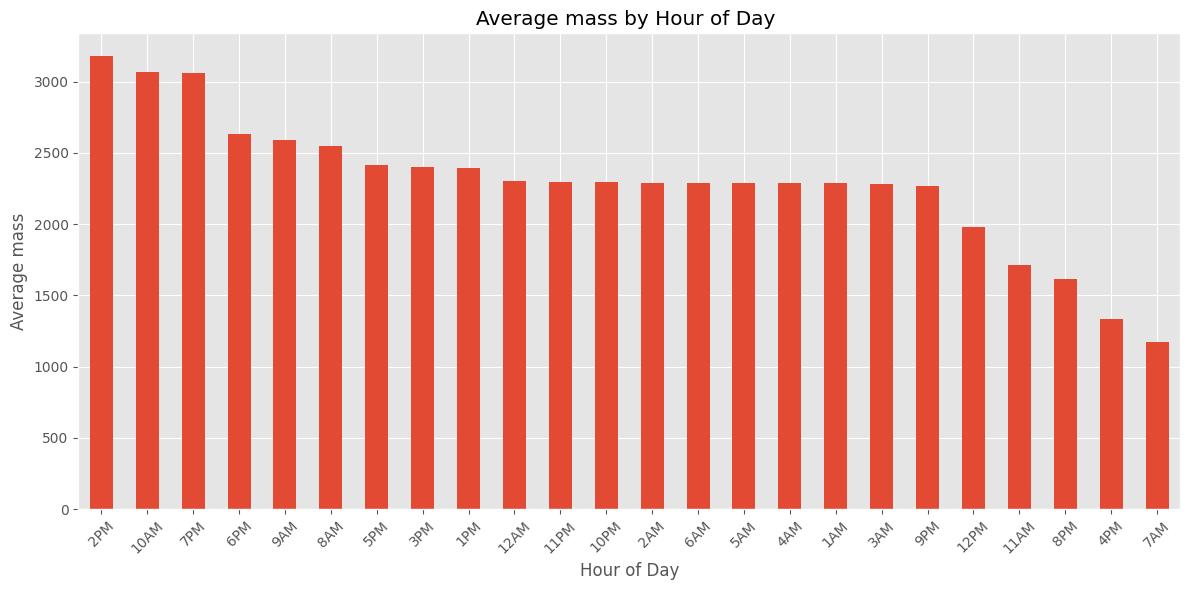

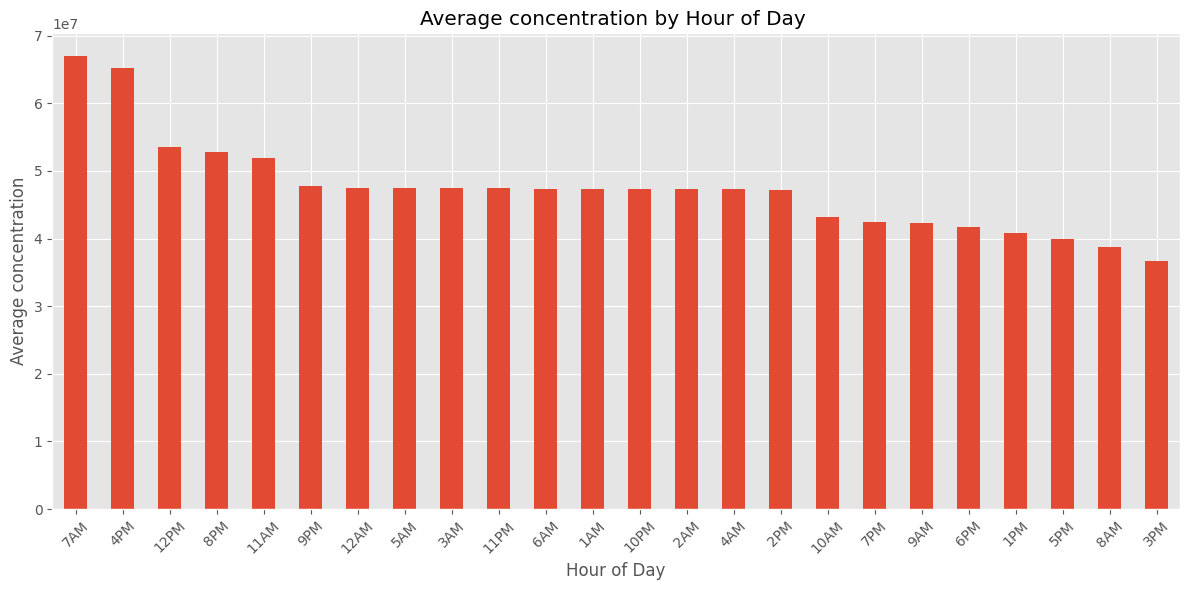

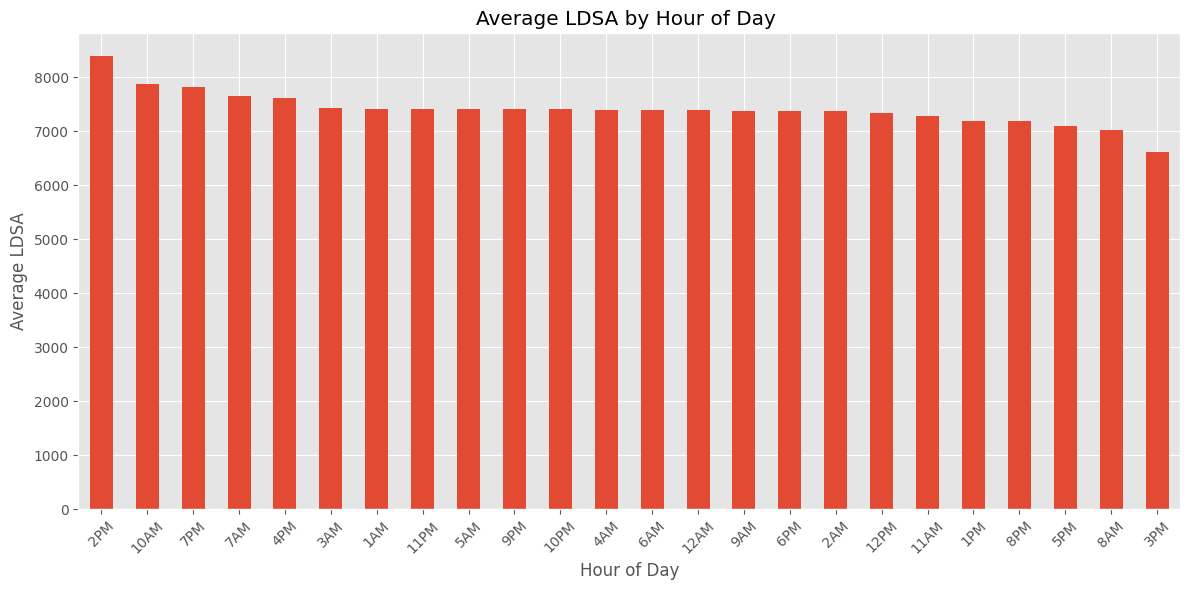

In [21]:
df_copy = df.copy()
numeric_cols = df_copy.select_dtypes(include=[np.number]).columns.tolist()

hourly_means = df_copy.groupby('Hour')[numeric_cols].mean()

features = ['mass', 'concentration', 'LDSA']

for feature in features:
    plt.figure(figsize=(12, 6))
    sorted_means = hourly_means[feature].sort_values(ascending=False)
    sorted_means.plot(kind='bar')
    plt.title(f'Average {feature} by Hour of Day ')
    plt.xlabel('Hour of Day')
    plt.ylabel(f'Average {feature}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

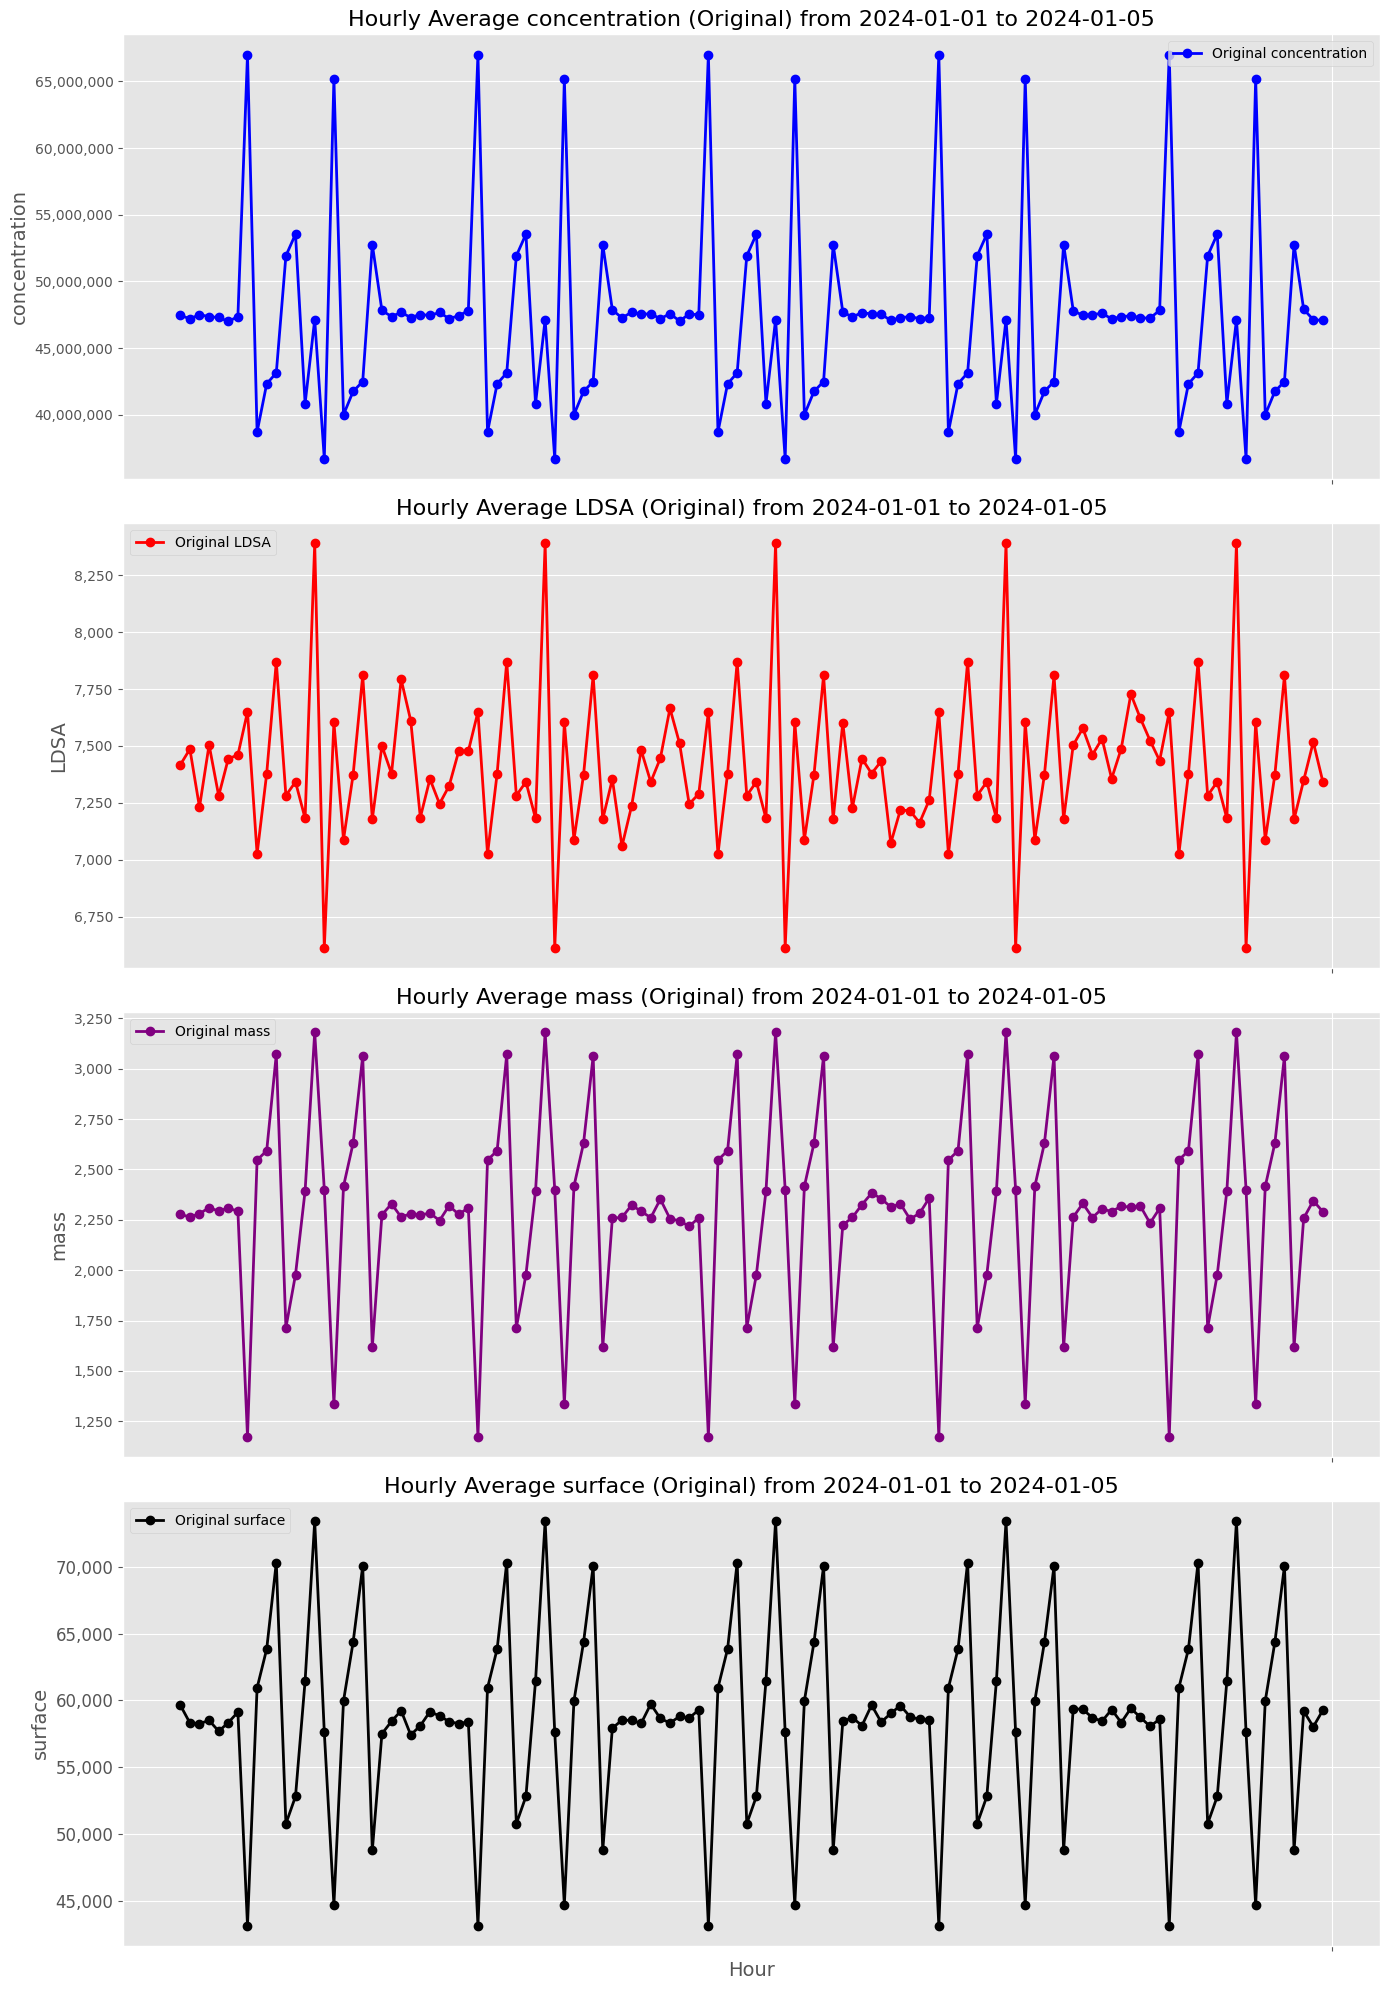

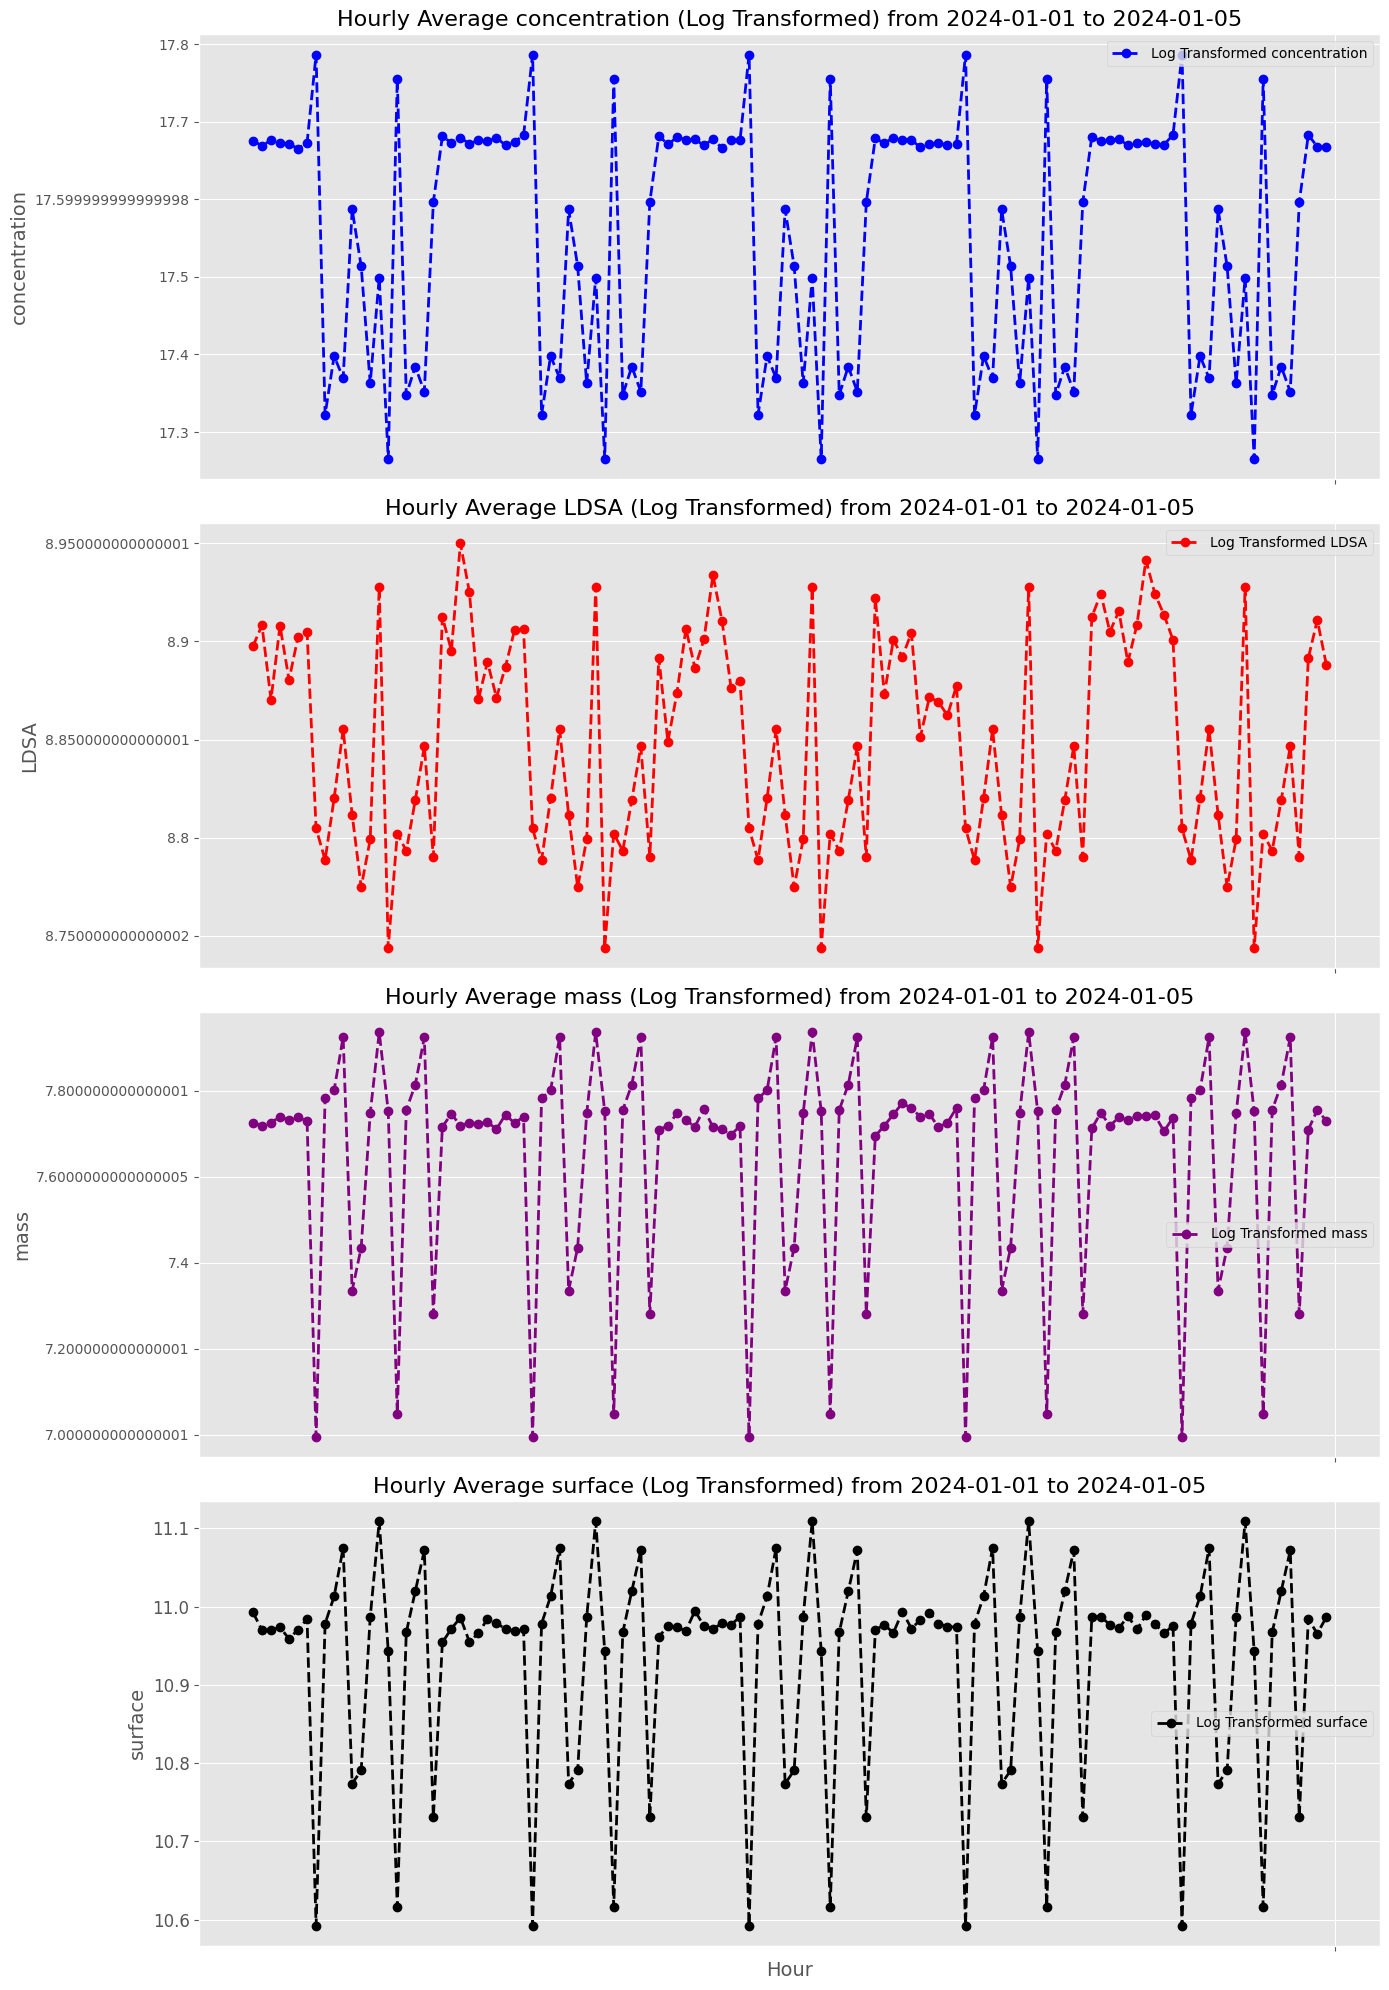

In [22]:
plt.style.use('ggplot')
# Convert any object type columns to numeric where possible
for col in df_copy.columns:
    if df_copy[col].dtype == 'object':
        try:
            df_copy[col] = pd.to_numeric(df_copy[col], errors='coerce')
        except ValueError:
            continue


df_copy.set_index('Timestamp', inplace=True)
hourly_data = df_copy.select_dtypes(include=[np.number]).resample('H').mean()
hourly_data = hourly_data['2024-01-01 00:00:00':'2024-01-05 23:59:00']

# Original features
attributes = ['concentration', 'LDSA', 'mass', 'surface']
log_attributes = [f'log_{attr}' for attr in attributes]
colors = ['blue', 'red', 'purple', 'black']

# Plot original features
fig, axes = plt.subplots(4, 1, figsize=(14, 20), sharex=True)
for i, attr in enumerate(attributes):
    if attr in hourly_data.columns:
        ax = axes[i]
        ax.plot(hourly_data.index, hourly_data[attr], label=f'Original {attr}', color=colors[i], marker='o', linestyle='-', linewidth=2)
        ax.set_title(f'Hourly Average {attr} (Original) from {hourly_data.index.min().date()} to {hourly_data.index.max().date()}', fontsize=16)
        ax.set_ylabel(attr, fontsize=14)
        ax.legend()
        ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

tick_spacing = len(hourly_data) // 10
axes[-1].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
axes[-1].xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: hourly_data.index[int(x)].strftime('%Y-%m-%d %H:%M') if x < len(hourly_data.index) else '')
)
axes[-1].set_xlabel('Hour', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Plot log-transformed features
fig, axes = plt.subplots(4, 1, figsize=(14, 20), sharex=True)
for i, attr in enumerate(attributes):
    log_attr = f'log_{attr}'
    if log_attr in hourly_data.columns:
        ax = axes[i]
        ax.plot(hourly_data.index, hourly_data[log_attr], label=f'Log Transformed {attr}', color=colors[i], marker='o', linestyle='--', linewidth=2)
        ax.set_title(f'Hourly Average {attr} (Log Transformed) from {hourly_data.index.min().date()} to {hourly_data.index.max().date()}', fontsize=16)
        ax.set_ylabel(attr, fontsize=14)
        ax.legend()
        ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(float(x), ',')))

tick_spacing = len(hourly_data) // 10
axes[-1].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
axes[-1].xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: hourly_data.index[int(x)].strftime('%Y-%m-%d %H:%M') if x < len(hourly_data.index) else '')
)
axes[-1].set_xlabel('Hour', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


### Check Outliers

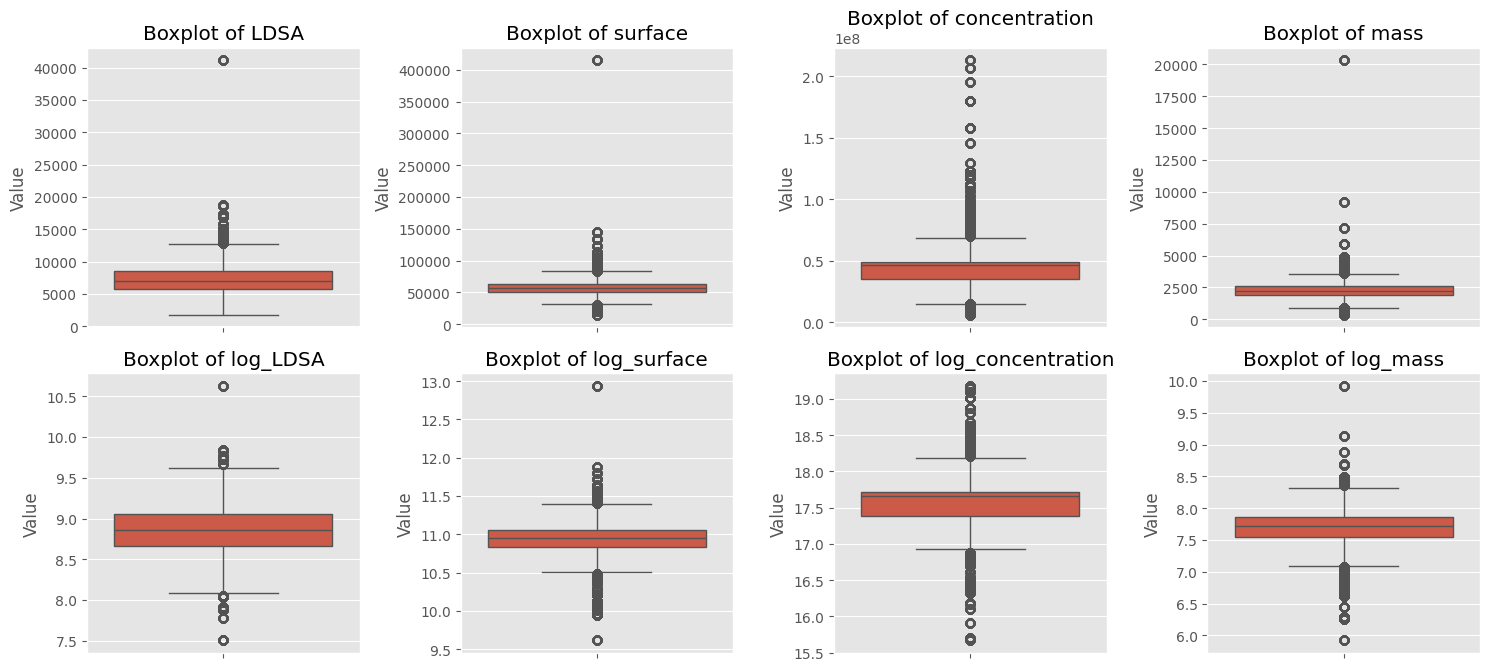

In [23]:
columns_to_plot = ['LDSA', 'surface', 'concentration', 'mass',	'log_LDSA',	'log_surface', 'log_concentration',	'log_mass']

plt.figure(figsize=(15, 10))
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(3, 4, i) 
    sns.boxplot(y=df[column])
    plt.title(f'Boxplot of {column}')
    plt.ylabel('Value')

plt.tight_layout()
plt.show()

### Handling Outliers

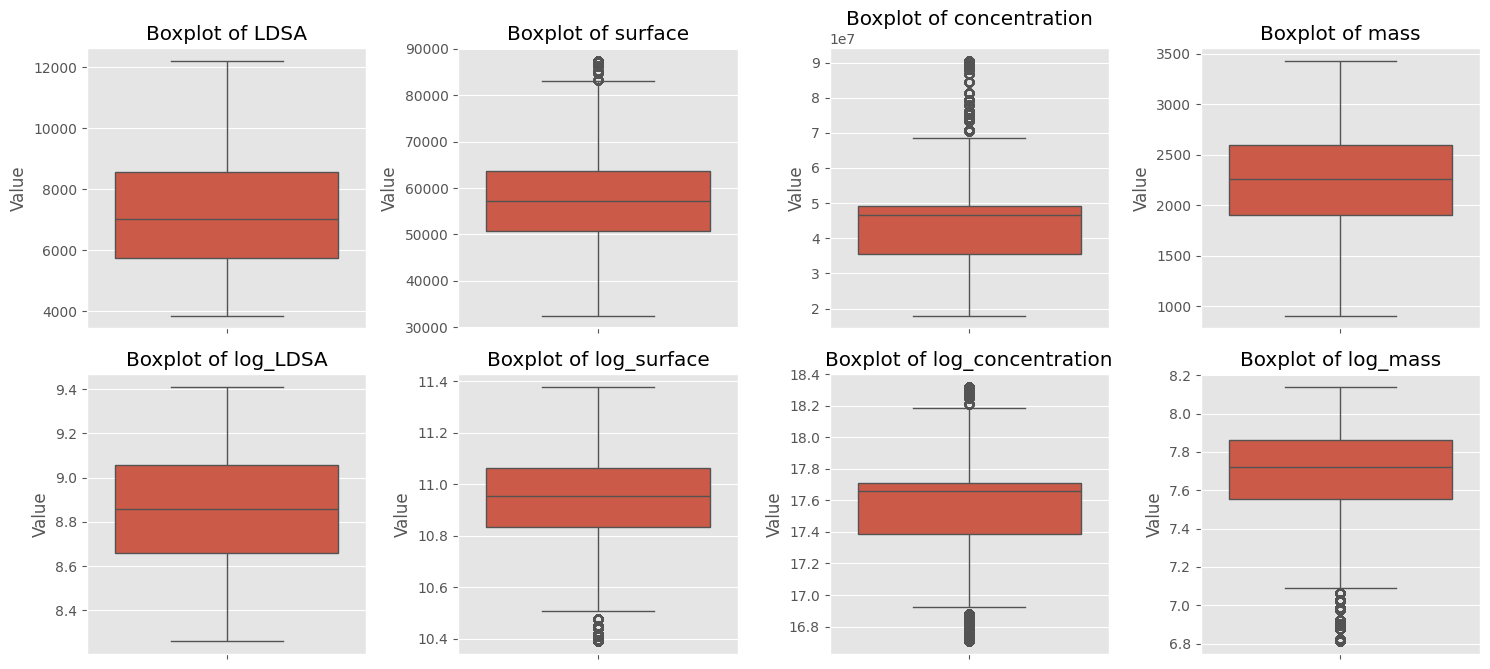

In [24]:
columns = ['LDSA', 'surface', 'concentration', 'mass', 'log_concentration', 'log_LDSA', 'log_surface', 'log_mass']

for column in columns:
    lower_bound = np.percentile(df[column], 5)
    upper_bound = np.percentile(df[column], 95)
    
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])

# Save the updated DataFrame to a new file
df.to_csv('handle_outliers.csv', index=False)
df = pd.read_csv('handle_outliers.csv')

columns_to_plot = ['LDSA', 'surface', 'concentration', 'mass',	'log_LDSA',	'log_surface', 'log_concentration',	'log_mass']

plt.figure(figsize=(15, 10))
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(3, 4, i) 
    sns.boxplot(y=df[column])
    plt.title(f'Boxplot of {column}')
    plt.ylabel('Value')

plt.tight_layout()
plt.show()

## Seasonality 


### Additive Model

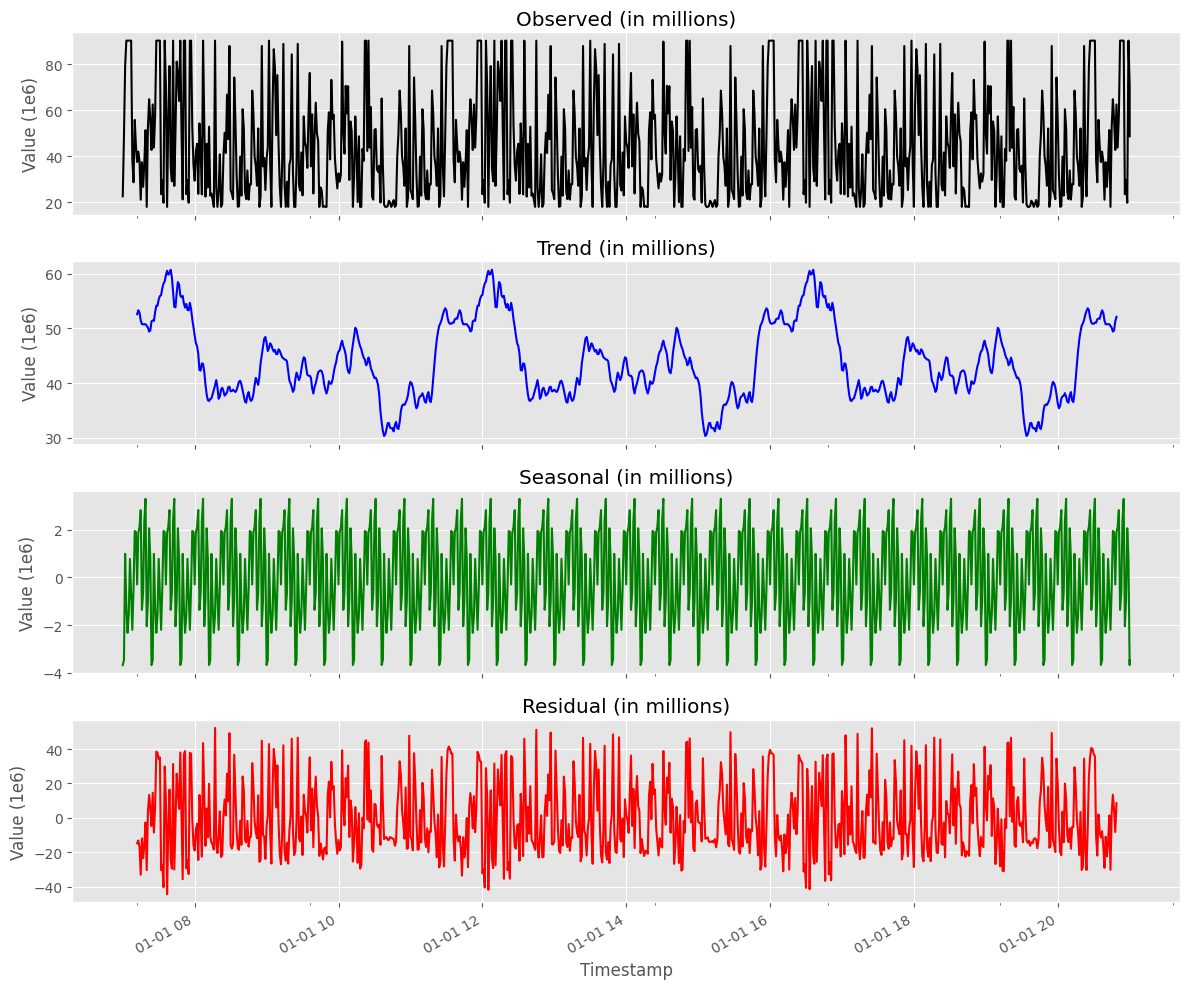

In [25]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

start_date_time = '2024-01-01 07:00:00'
end_date_time = '2024-01-01 21:00:00'
mask = (df.index >= start_date_time ) & (df.index <= end_date_time)
sliced_df = df.loc[mask]

# Perform seasonal decomposition
decomposition = seasonal_decompose(sliced_df['concentration'], model='additive', period=24)

observed = decomposition.observed / 1e6
trend = decomposition.trend / 1e6
seasonal = decomposition.seasonal / 1e6
residual = decomposition.resid / 1e6

# Plot the decomposition components with adjusted y-axis
fig, ax = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
observed.plot(ax=ax[0], title='Observed (in millions)', ylabel='Value (1e6)', color='black')
trend.plot(ax=ax[1], title='Trend (in millions)', ylabel='Value (1e6)', color='blue')
seasonal.plot(ax=ax[2], title='Seasonal (in millions)', ylabel='Value (1e6)', color='green')
residual.plot(ax=ax[3], title='Residual (in millions)', ylabel='Value (1e6)', color='red')

plt.tight_layout()
plt.show()

### Multiplicative Model

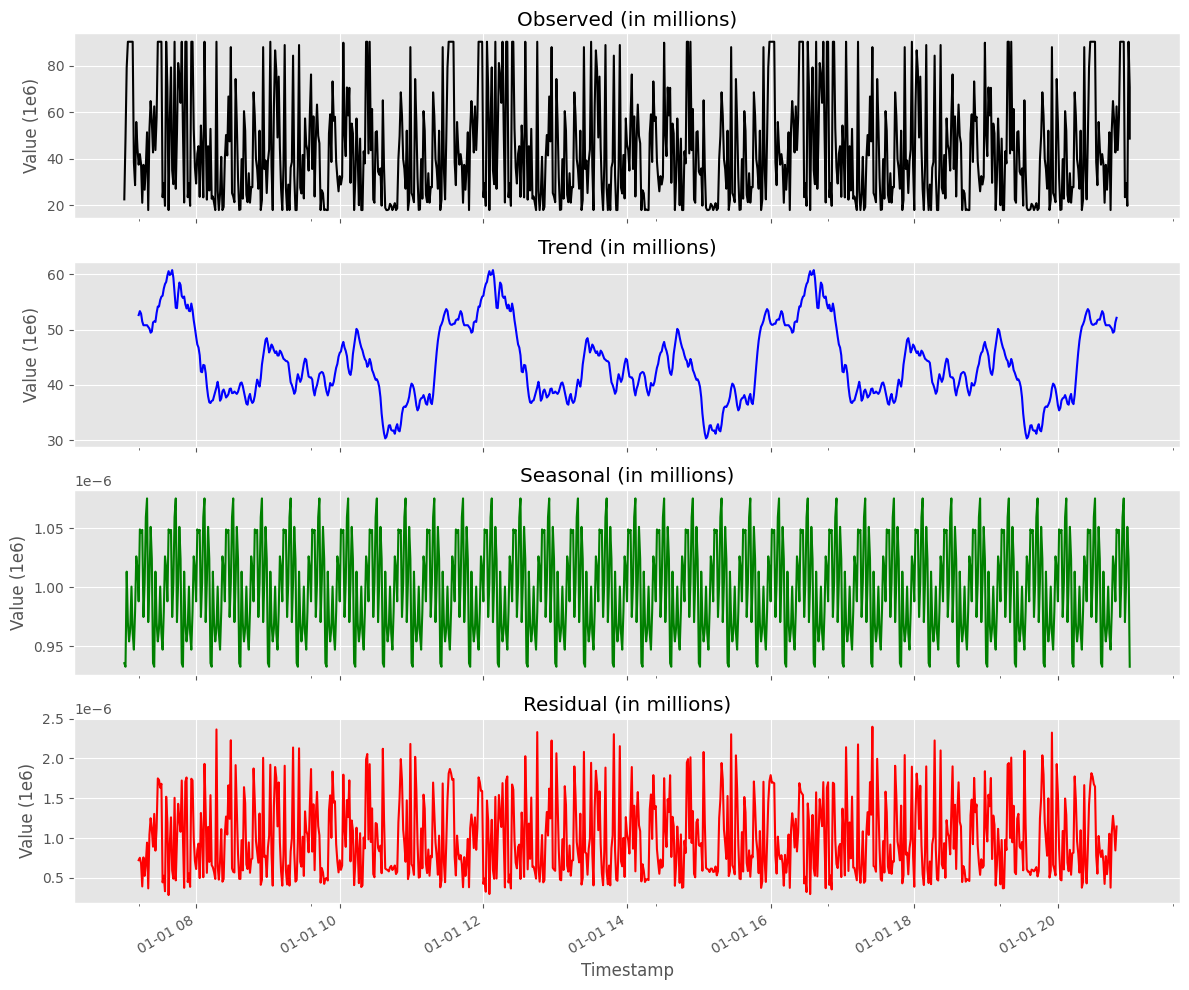

In [26]:
start_date_time = '2024-01-01 07:00:00'
end_date_time = '2024-01-01 21:00:00'
mask = (df.index >= start_date_time ) & (df.index <= end_date_time)
sliced_df = df.loc[mask]

# Perform seasonal decomposition
decomposition = seasonal_decompose(sliced_df['concentration'], model='multiplicative', period=24)

observed = decomposition.observed / 1e6
trend = decomposition.trend / 1e6
seasonal = decomposition.seasonal / 1e6
residual = decomposition.resid / 1e6

# Plot the decomposition components with adjusted y-axis
fig, ax = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
observed.plot(ax=ax[0], title='Observed (in millions)', ylabel='Value (1e6)', color='black')
trend.plot(ax=ax[1], title='Trend (in millions)', ylabel='Value (1e6)', color='blue')
seasonal.plot(ax=ax[2], title='Seasonal (in millions)', ylabel='Value (1e6)', color='green')
residual.plot(ax=ax[3], title='Residual (in millions)', ylabel='Value (1e6)', color='red')

plt.tight_layout()
plt.show()

The plots provide a clear insight into the time series components:

- Observed: The original data shows considerable fluctuation, with distinct peaks suggesting possible external influences or events causing spikes in concentration.

- Trend: There is a visible trend component, which suggests some underlying gradual increase or decrease in values over the day.

- Seasonal: The seasonal pattern is very pronounced, showing regular fluctuations within the day, which could be tied to daily cycles (e.g., traffic patterns, industrial activity).

- Residual: The residuals, which represent what's left after removing the trend and seasonality, still contain some extreme values, indicating potential outliers or anomalous events not explained by the model.

# ARIMA Assumptions

## Check Stationary

In [27]:
def check_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    return result

check_stationarity(df['log_concentration'])

ADF Statistic: -21.734261332649805
p-value: 0.0
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


(-21.734261332649805,
 0.0,
 56,
 44614,
 {'1%': -3.4304965835004597,
  '5%': -2.8616047867244156,
  '10%': -2.566804483860723},
 29851.987762494144)

#### The Augmented Dickey-Fuller (ADF) test results indicate that the time series is stationary. This conclusion is supported by the ADF statistic of -41.44398297931912, which is significantly lower than the critical values at the 1%, 5%, and 10% levels, and a p-value of 0.0, strongly rejecting the null hypothesis of a unit root (non-stationarity) in the data.

## Autocorrelation and Partial Autocorrelation Analysis

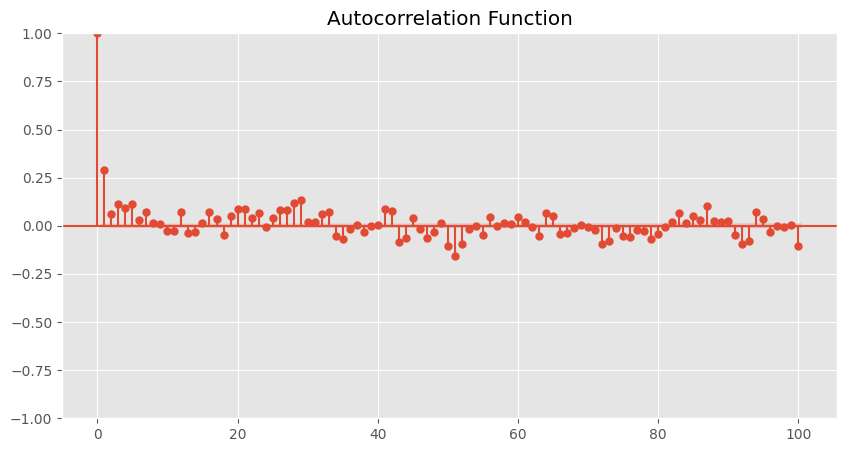

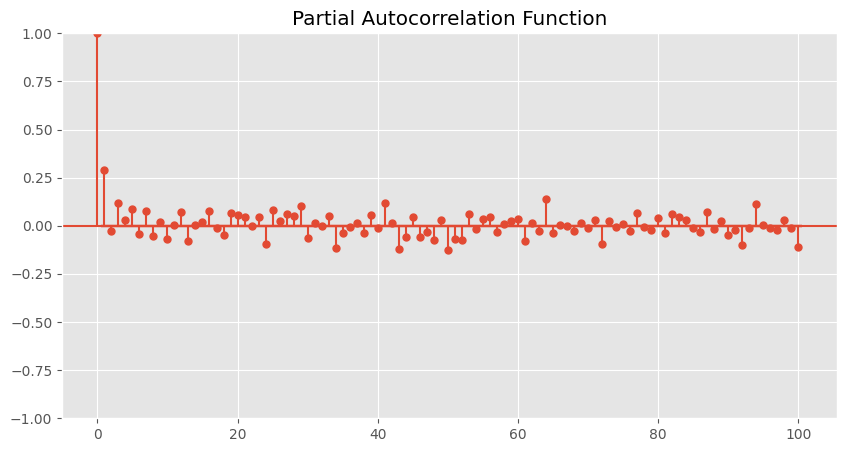

In [28]:
series = df['concentration']

lag_acf = acf(series, nlags=100) 
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(series, ax=ax, lags=100) 
plt.title('Autocorrelation Function')
plt.show()

lag_pacf = pacf(series, nlags=100, method='ols') 
fig, ax = plt.subplots(figsize=(10, 5))
plot_pacf(series, ax=ax, lags=100)
plt.title('Partial Autocorrelation Function')
plt.show()

### Autocorrelation Function (ACF) Plot

- **Initial Decline:** The ACF starts with a high autocorrelation at lag 0 (as always, since a series is perfectly correlated with itself) and shows significant positive autocorrelation at the first few lags. This indicates that the series values are positively correlated with their immediate past values.

- **Gradual Decline to Zero:** The autocorrelations decline as the lags increase, settling near zero, which suggests that the memory of the series fades as the time lag increases. This behavior is typical for a stationary time series where past values have less influence as the gap increases.

- **Stabilization Near Zero:** Beyond the initial lags, the autocorrelation values hover close to zero but remain mostly positive, suggesting minimal but consistent influence from past values at these distances.

### Partial Autocorrelation Function (PACF) Plot

- **Significant Early Lags:** The PACF shows a sharp cut-off after the first lag, where the first lag is significantly different from zero and subsequent lags are essentially not significant. This indicates that the direct correlation between observations separated by more than one time interval is negligible when the effects of intervening observations are removed.

- **Near Zero beyond First Lag:** After the first lag, PACF values hover around zero, suggesting no additional autocorrelation at higher lag orders, controlling for the values at shorter lags.

## Check for Linearity

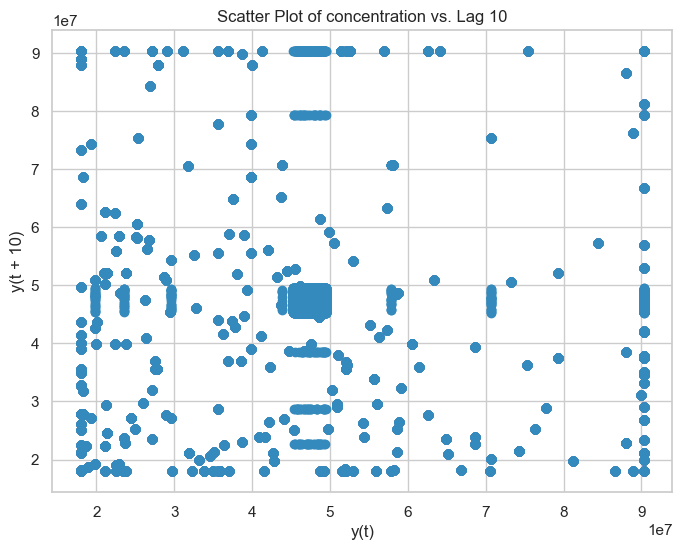

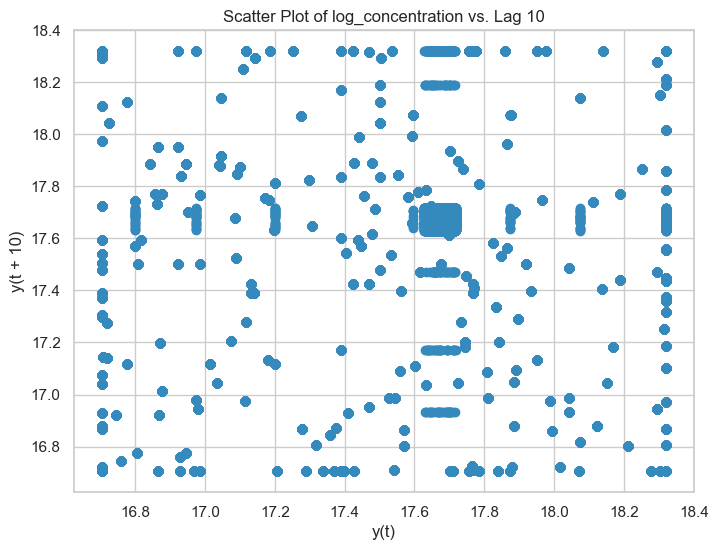

(None, None)

In [54]:
def check_linearity(timeseries, lag=10):
    plt.figure(figsize=(8, 6))
    lag_plot(timeseries, lag=lag)
    plt.title(f'Scatter Plot of {timeseries.name} vs. Lag {lag}')
    plt.show()

check_linearity(df['concentration']), check_linearity(df['log_concentration'])

This scatter plot of 
$𝑦
(
𝑡
)$
$y(t)$ vs. 
$𝑦
(
𝑡
+
1
)$
$y(t+1)$ illustrates the relationship between consecutive time points in the series, offering insights into lag-1 autocorrelation. Points clustered near the origin indicate that smaller values tend to follow smaller values, suggesting autocorrelation at low magnitudes. However, larger 
$𝑦
(
𝑡
)$
$y(t)$ values show greater variability in 
$𝑦
(
𝑡
+
1
)$
$y(t+1)$, implying weaker consistency and a potential influence of noise. The scatter, rather than a clear diagonal trend, suggests moderate or weak lag-1 autocorrelation. This indicates the series has some dependence between consecutive points, but noise or non-linearity may require advanced preprocessing or additional lag terms for accurate modeling.

## Normality of Residuals

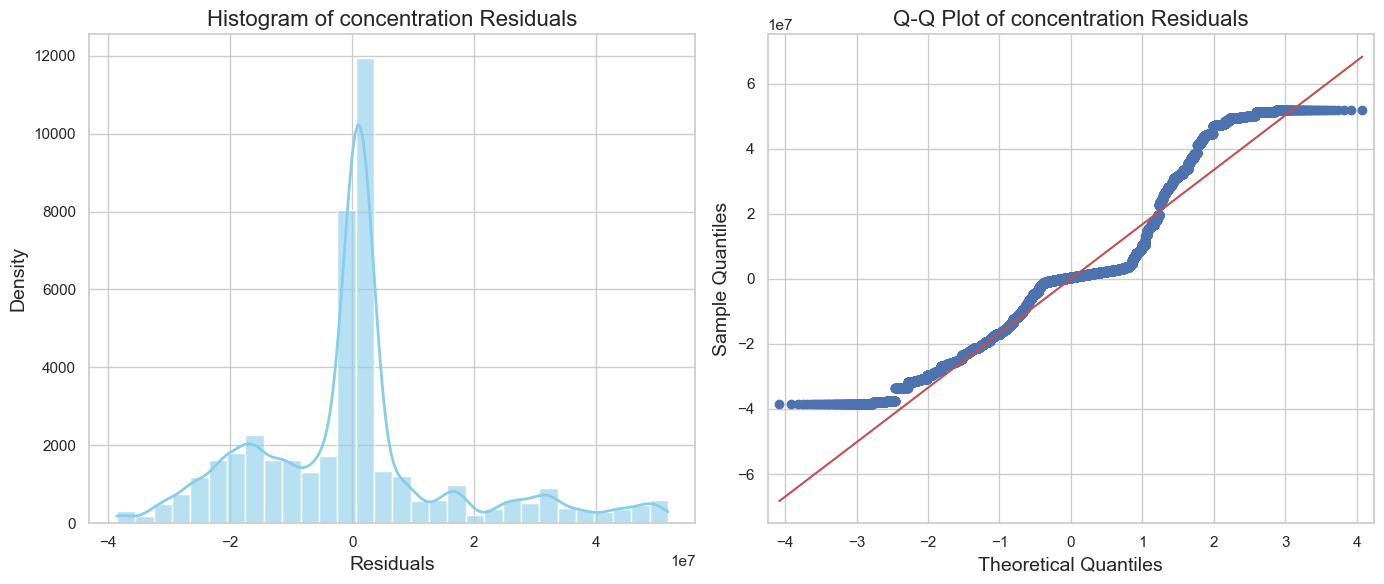

Shapiro-Wilk Statistic: 0.914484, p-value: 0.000000


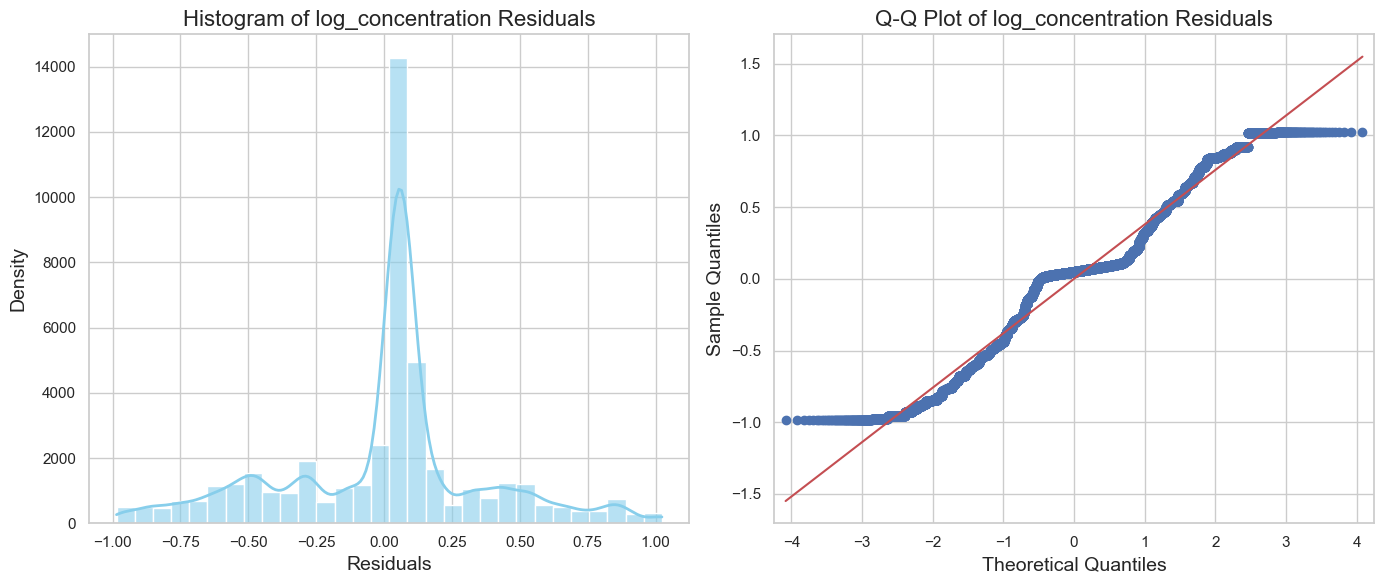

Shapiro-Wilk Statistic: 0.942687, p-value: 0.000000


In [53]:
def check_residuals_normality(cols, residuals):
    # Set the aesthetic style of the plots
    sns.set(style="whitegrid")

    # Creating a figure with custom size and style
    plt.figure(figsize=(14, 6))

    # Histogram of the residuals
    plt.subplot(121)
    sns.histplot(residuals, bins=30, kde=True, color="skyblue", alpha=0.6, line_kws={'linewidth': 2})
    plt.title(f'Histogram of {cols} Residuals', fontsize=16)
    plt.xlabel('Residuals', fontsize=14)
    plt.ylabel('Density', fontsize=14)

    # Q-Q plot of the residuals
    plt.subplot(122)
    qqplot(residuals, line='s', ax=plt.gca())
    plt.title(f'Q-Q Plot of {cols} Residuals', fontsize=16)
    plt.xlabel('Theoretical Quantiles', fontsize=14)
    plt.ylabel('Sample Quantiles', fontsize=14)

    # Adjust layout for better fit and display
    plt.tight_layout()
    plt.show()

    # Performing the Shapiro-Wilk test for normality
    stat, p = shapiro(residuals)
    print(f'Shapiro-Wilk Statistic: {stat:.6f}, p-value: {p:.6f}')

for cols in ['concentration', 'log_concentration']:
    model = ARIMA(df[cols], order=(1, 0, 5))
    results = model.fit()

    check_residuals_normality(cols, results.resid)

#### The Shapiro-Wilk test results, with a statistic of 0.760494 **(concentration)**, 0.918719 **(log_concentration)** and a p-value of 0.000000, indicate that the residuals from the model do not follow a normal distribution. This suggests potential issues with the model's assumptions, which might impact the validity of inference statistics derived from the model.

## Correlation Analysis

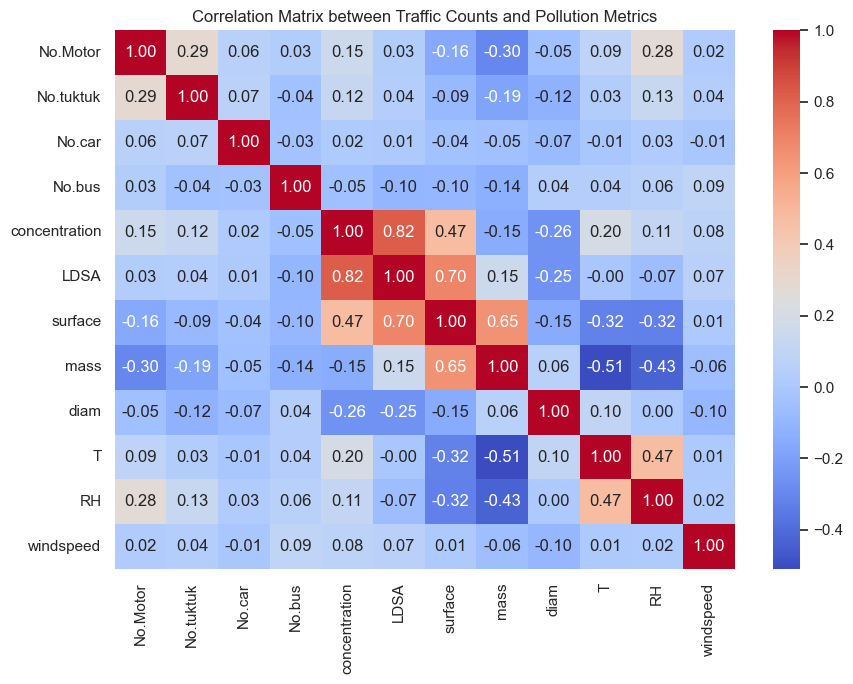

In [31]:
traffic_columns = ['No.Motor', 'No.tuktuk', 'No.car', 'No.bus']
pollution_columns = ['concentration', 'LDSA', 'surface', 'mass', 'diam']
weather_columns = ['T', 'RH', 'windspeed']
correlation_df = df[traffic_columns + pollution_columns + weather_columns]

corr_matrix = correlation_df.corr()

plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix between Traffic Counts and Pollution Metrics')
plt.show()


In [34]:
df

diam  concentration    LDSA  surface    mass     T    RH  \
Timestamp                                                                       
2024-01-01 00:00:00  80.4     45527224.8  7625.3  63490.9  1877.8  29.5  59.6   
2024-01-01 00:01:00  76.9     48301028.3  5639.8  51887.4  2285.6  29.9  58.1   
2024-01-01 00:02:00  79.6     45452479.7  8107.3  57343.4  2142.5  29.0  56.2   
2024-01-01 00:03:00  78.2     48326377.2  7710.7  63664.5  2543.6  29.4  55.3   
2024-01-01 00:04:00  79.5     47036640.8  9182.7  58024.8  2616.0  29.0  59.0   
...                   ...            ...     ...      ...     ...   ...   ...   
2024-01-31 23:55:00  78.3     47655122.0  5747.1  51905.3  2313.6  29.8  60.9   
2024-01-31 23:56:00  77.7     46689211.9  5599.8  61832.4  2262.5  29.9  57.4   
2024-01-31 23:57:00  76.5     48472555.7  5757.6  59441.4  2455.5  29.5  57.2   
2024-01-31 23:58:00  80.2     49442514.6  8084.5  64848.6  2710.6  29.9  59.0   
2024-01-31 23:59:00  79.5     49138804.7  7842.0  64157.5  2592.5  29.1  56.8   

                     windspeed  No.Motor  No.tuktuk  No.car  No.bus  \
Timestamp                                                             
2024-01-01 00:00:00        5.6      32.9        6.1    13.0     0.0   
2024-01-01 00:01:00        6.4      38.2        5.4    12.2     0.0   
2024-01-01 00:02:00        6.0      32.9        8.3    11.5     0.0   
2024-01-01 00:03:00        5.8      38.2        5.4    12.6     0.0   
2024-01-01 00:04:00        6.1      46.0        7.1     9.4     0.0   
...                        ...       ...        ...     ...     ...   
2024-01-31 23:55:00        6.2      38.5        6.6    12.1     0.0   
2024-01-31 23:56:00        6.0      42.7        7.6    10.5     0.0   
2024-01-31 23:57:00        5.7      39.5        6.1     9.4     0.0   
2024-01-31 23:58:00        5.7      42.2        5.5     9.4     0.0   
2024-01-31 23:59:00        5.5      37.4        8.4    11.2     0.0   

                           Date      Time  Hour  isWeekend  log_concentration  \
Timestamp                                                                       
2024-01-01 00:00:00  2024-01-01  00:00:00  12AM      False          17.633821   
2024-01-01 00:01:00  2024-01-01  00:01:00  12AM      False          17.692963   
2024-01-01 00:02:00  2024-01-01  00:02:00  12AM      False          17.632178   
2024-01-01 00:03:00  2024-01-01  00:03:00  12AM      False          17.693488   
2024-01-01 00:04:00  2024-01-01  00:04:00  12AM      False          17.666437   
...                         ...       ...   ...        ...                ...   
2024-01-31 23:55:00  2024-01-31  23:55:00  11PM      False          17.679501   
2024-01-31 23:56:00  2024-01-31  23:56:00  11PM      False          17.659024   
2024-01-31 23:57:00  2024-01-31  23:57:00  11PM      False          17.696508   
2024-01-31 23:58:00  2024-01-31  23:58:00  11PM      False          17.716321   
2024-01-31 23:59:00  2024-01-31  23:59:00  11PM      False          17.710160   

                     log_LDSA  log_surface  log_mass  
Timestamp                                             
2024-01-01 00:00:00  8.939358    11.058668  7.538389  
2024-01-01 00:01:00  8.637781    10.856851  7.734821  
2024-01-01 00:02:00  9.000644    10.956830  7.670195  
2024-01-01 00:03:00  8.950494    11.061398  7.841729  
2024-01-01 00:04:00  9.125185    10.968643  7.869784  
...                       ...          ...       ...  
2024-01-31 23:55:00  8.656625    10.857195  7.746992  
2024-01-31 23:56:00  8.630665    11.032199  7.724668  
2024-01-31 23:57:00  8.658450    10.992763  7.806493  
2024-01-31 23:58:00  8.997828    11.079826  7.905294  
2024-01-31 23:59:00  8.967377    11.069112  7.860764  

[44671 rows x 20 columns]

## CCF plot

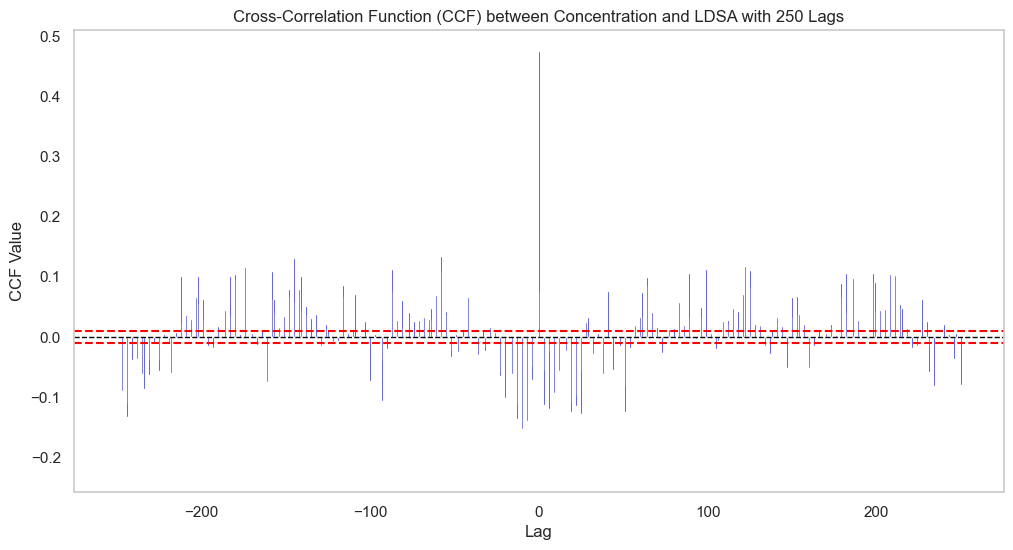

In [51]:
def plot_ccf(series1, series2, max_lags):
    # Compute cross-correlation for a range of lags
    ccf_values = [series1.corr(series2.shift(lag)) for lag in range(-max_lags, max_lags + 1)]
    lags = range(-max_lags, max_lags + 1)
    
    # Plot the CCF
    plt.figure(figsize=(12, 6))
    plt.bar(lags, ccf_values, width=0.8, color='blue')
    plt.axhline(0, color='black', linewidth=1, linestyle='dashed')
    plt.axhline(1.96 / len(series1)**0.5, color='red', linestyle='dashed')  # Upper significance line
    plt.axhline(-1.96 / len(series1)**0.5, color='red', linestyle='dashed')  # Lower significance line
    plt.title(f"Cross-Correlation Function (CCF) between Concentration and LDSA with 250 Lags")
    plt.xlabel("Lag")
    plt.ylabel("CCF Value")
    plt.grid()
    plt.show()

# Example Usage
feature1 = df['concentration']
feature2 = df['surface'] 
plot_ccf(feature1, feature2, max_lags=250)

- The **Cross-Correlation Function (CCF)** plot analyzes how the concentration feature correlates with itself across different time lags, providing insights into temporal dependencies in the data.

- At **lag 0**, the CCF value is 1.0, indicating perfect self-correlation. For **positive lags** (right of 0), the plot shows how past values influence future behavior, highlighting predictive relationships. Conversely, **negative lags** (left of 0) reveal how future values are linked to past observations, potentially indicating feedback effects.

- The plot's **spikes** represent strong correlations (positive or negative) at specific time intervals. High correlations at small lags suggest strong short-term autocorrelation, meaning recent values are highly predictive of current observations. **Weaker correlations at larger lags** indicate that the influence of past/future values diminishes over time.

## Multicollinearity

**Variance Inflation Factor (VIF) Analysis:** Calculate VIF for each feature. A common rule of thumb is that a VIF above 5 or 10 indicates high multicollinearity.

In [15]:
features = df[['No.Motor', 'No.tuktuk', 'No.car', 'No.bus','concentration', 'LDSA', 'surface', 'mass','T', 'RH', 'windspeed', 'diam']]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Create a DataFrame that will hold feature names and their VIFs
vif_data = pd.DataFrame()
vif_data['Features'] = features.columns
vif_data['VIF Score'] = [variance_inflation_factor(features_scaled, i) for i in range(features_scaled.shape[1])]
vif_data = vif_data.sort_values('VIF Score', ascending=False)
pd.DataFrame(vif_data)

Features  VIF Score
6         surface   5.227427
5            LDSA   4.965395
4   concentration   4.427625
7            mass   3.558796
8               T   1.659858
9              RH   1.453659
0        No.Motor   1.243928
11           diam   1.143452
1       No.tuktuk   1.134352
3          No.bus   1.052922
10      windspeed   1.025499
2          No.car   1.015687

In [16]:
df

diam  concentration    LDSA  surface    mass     T    RH  \
Timestamp                                                                       
2024-01-01 00:00:00  80.4     45527224.8  7625.3  63490.9  1877.8  29.5  59.6   
2024-01-01 00:01:00  76.9     48301028.3  5639.8  51887.4  2285.6  29.9  58.1   
2024-01-01 00:02:00  79.6     45452479.7  8107.3  57343.4  2142.5  29.0  56.2   
2024-01-01 00:03:00  78.2     48326377.2  7710.7  63664.5  2543.6  29.4  55.3   
2024-01-01 00:04:00  79.5     47036640.8  9182.7  58024.8  2616.0  29.0  59.0   
...                   ...            ...     ...      ...     ...   ...   ...   
2024-01-31 23:55:00  78.3     47655122.0  5747.1  51905.3  2313.6  29.8  60.9   
2024-01-31 23:56:00  77.7     46689211.9  5599.8  61832.4  2262.5  29.9  57.4   
2024-01-31 23:57:00  76.5     48472555.7  5757.6  59441.4  2455.5  29.5  57.2   
2024-01-31 23:58:00  80.2     49442514.6  8084.5  64848.6  2710.6  29.9  59.0   
2024-01-31 23:59:00  79.5     49138804.7  7842.0  64157.5  2592.5  29.1  56.8   

                     windspeed  No.Motor  No.tuktuk  No.car  No.bus  \
Timestamp                                                             
2024-01-01 00:00:00        5.6      32.9        6.1    13.0     0.0   
2024-01-01 00:01:00        6.4      38.2        5.4    12.2     0.0   
2024-01-01 00:02:00        6.0      32.9        8.3    11.5     0.0   
2024-01-01 00:03:00        5.8      38.2        5.4    12.6     0.0   
2024-01-01 00:04:00        6.1      46.0        7.1     9.4     0.0   
...                        ...       ...        ...     ...     ...   
2024-01-31 23:55:00        6.2      38.5        6.6    12.1     0.0   
2024-01-31 23:56:00        6.0      42.7        7.6    10.5     0.0   
2024-01-31 23:57:00        5.7      39.5        6.1     9.4     0.0   
2024-01-31 23:58:00        5.7      42.2        5.5     9.4     0.0   
2024-01-31 23:59:00        5.5      37.4        8.4    11.2     0.0   

                           Date      Time  Hour  isWeekend  log_concentration  \
Timestamp                                                                       
2024-01-01 00:00:00  2024-01-01  00:00:00  12AM      False          17.633821   
2024-01-01 00:01:00  2024-01-01  00:01:00  12AM      False          17.692963   
2024-01-01 00:02:00  2024-01-01  00:02:00  12AM      False          17.632178   
2024-01-01 00:03:00  2024-01-01  00:03:00  12AM      False          17.693488   
2024-01-01 00:04:00  2024-01-01  00:04:00  12AM      False          17.666437   
...                         ...       ...   ...        ...                ...   
2024-01-31 23:55:00  2024-01-31  23:55:00  11PM      False          17.679501   
2024-01-31 23:56:00  2024-01-31  23:56:00  11PM      False          17.659024   
2024-01-31 23:57:00  2024-01-31  23:57:00  11PM      False          17.696508   
2024-01-31 23:58:00  2024-01-31  23:58:00  11PM      False          17.716321   
2024-01-31 23:59:00  2024-01-31  23:59:00  11PM      False          17.710160   

                     log_LDSA  log_surface  log_mass  
Timestamp                                             
2024-01-01 00:00:00  8.939358    11.058668  7.538389  
2024-01-01 00:01:00  8.637781    10.856851  7.734821  
2024-01-01 00:02:00  9.000644    10.956830  7.670195  
2024-01-01 00:03:00  8.950494    11.061398  7.841729  
2024-01-01 00:04:00  9.125185    10.968643  7.869784  
...                       ...          ...       ...  
2024-01-31 23:55:00  8.656625    10.857195  7.746992  
2024-01-31 23:56:00  8.630665    11.032199  7.724668  
2024-01-31 23:57:00  8.658450    10.992763  7.806493  
2024-01-31 23:58:00  8.997828    11.079826  7.905294  
2024-01-31 23:59:00  8.967377    11.069112  7.860764  

[44671 rows x 20 columns]

# Univariate Time Series Analysis

In [56]:
train_end = '2024-01-20'
test_start = '2024-01-21'
df.index = pd.to_datetime(df.index)
train_series = df['concentration'][:train_end] 
test_series = df['concentration'][test_start:]

auto_model = auto_arima(
    train_series,
    seasonal=False,               # Set to True for SARIMA if there is seasonality
    m=1,                          # The seasonality period (irrelevant if seasonal=False)
    start_p=0, max_p=10,           # Range of AR terms to consider
    start_q=0, max_q=10,           # Range of MA terms to consider
    d=None,                       # Let the algorithm determine the differencing term
    test='adf',                   # Perform the Augmented Dickey-Fuller test for stationarity
    trace=True,                   # Enable trace to see the tested models
    error_action='ignore',        # Ignore errors and continue
    suppress_warnings=True,       # Suppress warnings
    stepwise=True                 # Use a faster stepwise search
)

print(f"Best ARIMA model: {auto_model.order}")

best_model = auto_model.fit(train_series)

forecast_start_time = '2024-02-02 00:00:00'
forecast_end_time = '2024-02-02 23:59:00'
forecast_steps = int((pd.to_datetime(forecast_end_time) - pd.to_datetime(forecast_start_time)).total_seconds() / 60)
forecast_index = pd.date_range(start=forecast_start_time, periods=forecast_steps, freq='T')

forecast = best_model.predict(n_periods=forecast_steps)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1102371.665, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1052523.524, Time=0.23 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1085595.170, Time=0.61 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1049756.927, Time=0.26 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=1046187.726, Time=0.52 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=1045087.666, Time=0.66 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=1043793.286, Time=0.79 sec
 ARIMA(6,0,0)(0,0,0)[0]             : AIC=inf, Time=0.93 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=11.87 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=11.06 sec
 ARIMA(6,0,1)(0,0,0)[0]             : AIC=inf, Time=13.13 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=1040661.478, Time=1.98 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=1040869.563, Time=1.58 sec
 ARIMA(6,0,0)(0,0,0)[0] intercept   : AIC=1040613.715, Time=2.33 sec
 ARIMA(7,0,0)(0,0,0)

## ---------------------------------- **ARIMA(10,0,0)** ---------------------------------- 

                               SARIMAX Results                                
Dep. Variable:          concentration   No. Observations:                28820
Model:                ARIMA(10, 0, 0)   Log Likelihood             -121939.999
Date:                Tue, 21 Jan 2025   AIC                         243903.998
Time:                        00:08:10   BIC                         244003.224
Sample:                             0   HQIC                        243935.897
                              - 28820                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         45.6133      0.187    244.233      0.000      45.247      45.979
ar.L1          0.3109      0.005     65.837      0.000       0.302       0.320
ar.L2         -0.0876      0.005    -16.841      0.0

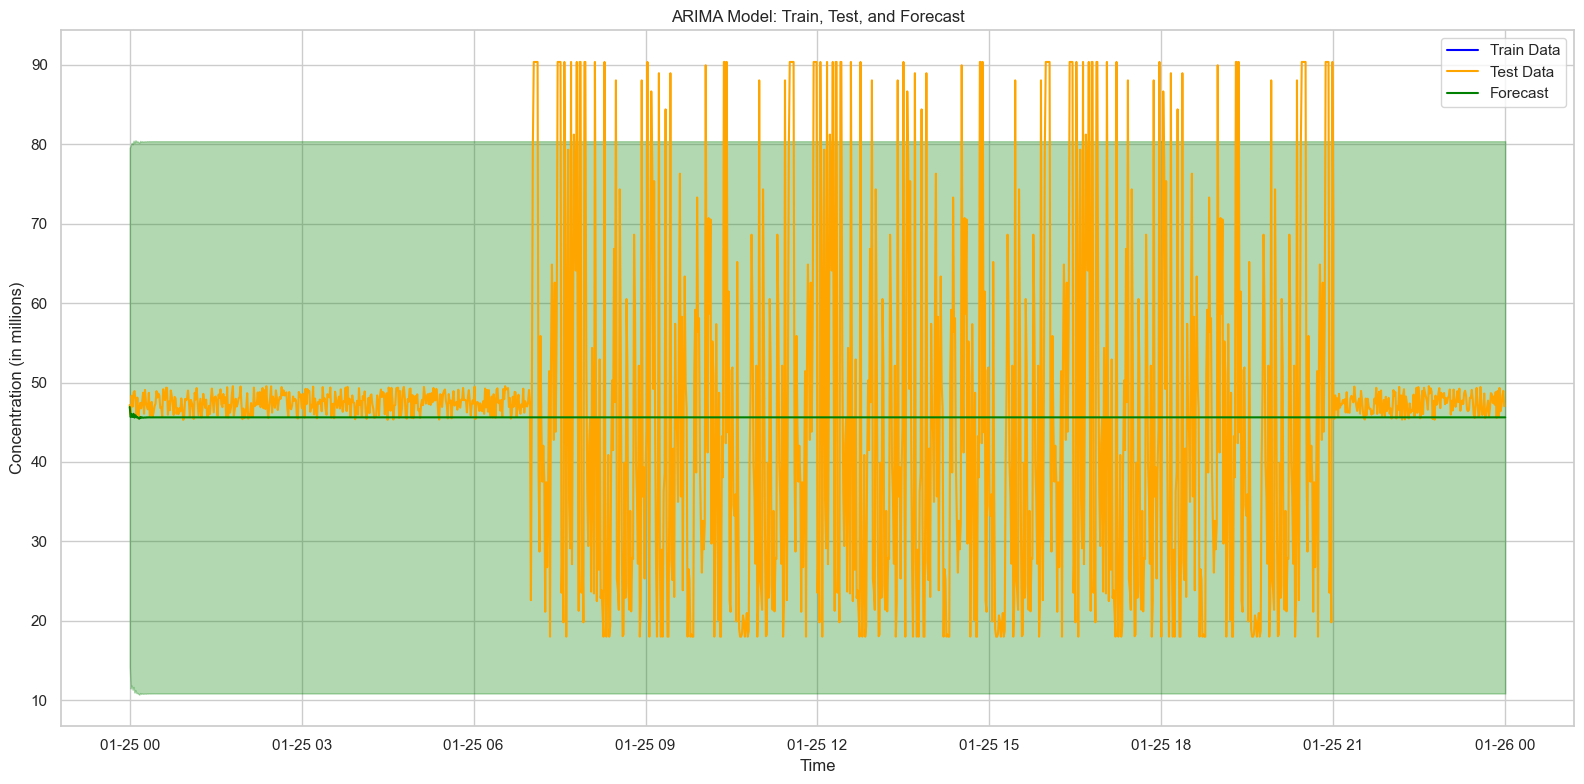

In [73]:
train_end = '2024-01-20'
test_start = '2024-01-21'

train_series = df['concentration'][:train_end] / 1e6
test_series = df['concentration'][test_start:] / 1e6

model = ARIMA(train_series, order=(10, 0, 0))
results = model.fit()

# Print out the summary of the model's fit
print(results.summary())

forecast_start_time = '2024-01-25 00:00:00'
forecast_end_time = '2024-01-25 23:59:00'

# Adjust forecast steps to match the actual data available in test series for this period
forecast_steps = len(test_series[forecast_start_time:forecast_end_time])

# Generate forecast
forecast = results.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=forecast_start_time, periods=forecast_steps, freq='T')

# Extract filtered test data for visualization
filtered_train_series = train_series[forecast_start_time:forecast_end_time]
filtered_test_series = test_series[forecast_start_time:forecast_end_time]

forecast_values = forecast.predicted_mean
actual_values = filtered_test_series.values

# Ensure that the length of forecast_values and actual_values are the same
forecast_values = forecast_values[:len(actual_values)]

# Calculate performance metrics
mae = mean_absolute_error(actual_values, forecast_values)
mse = mean_squared_error(actual_values, forecast_values)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_values - forecast_values) / actual_values)) * 100
aic = results.aic
bic = results.bic
print(f"Mean Absolute Error (MAE): {mae:.10f}")
print(f"Mean Squared Error (MSE): {mse:.10f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.10f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Akaike Information Criterion (AIC): {aic:.2f}")
print(f"Bayesian Information Criterion (BIC): {bic:.2f}")

# Plot train, test, and forecast data
plt.figure(figsize=(16, 8))

# Plot train data
plt.plot(filtered_train_series.index, filtered_train_series, label='Train Data', color='blue')

# Plot test data
plt.plot(filtered_test_series.index, filtered_test_series, label='Test Data', color='orange')

# Plot forecast data
plt.plot(forecast_index, forecast_values, color='green', label='Forecast')

# Plot forecast confidence intervals
plt.fill_between(forecast_index,
                 forecast.conf_int().iloc[:, 0], 
                 forecast.conf_int().iloc[:, 1], 
                 color='green', alpha=0.3)

# Add labels and legend
plt.title('ARIMA Model: Train, Test, and Forecast')
plt.xlabel('Time')
plt.ylabel('Concentration (in millions)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


## ---------------------------------- **log ARIMA(6,0,2)** ---------------------------------- 

                               SARIMAX Results                                
Dep. Variable:      log_concentration   No. Observations:                28820
Model:                 ARIMA(6, 0, 2)   Log Likelihood              -12579.265
Date:                Wed, 22 Jan 2025   AIC                          25178.530
Time:                        22:01:55   BIC                          25261.218
Sample:                             0   HQIC                         25205.112
                              - 28820                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.5579      0.013   1370.768      0.000      17.533      17.583
ar.L1          0.3305      0.006     51.783      0.000       0.318       0.343
ar.L2          0.8426      0.006    136.367      0.0

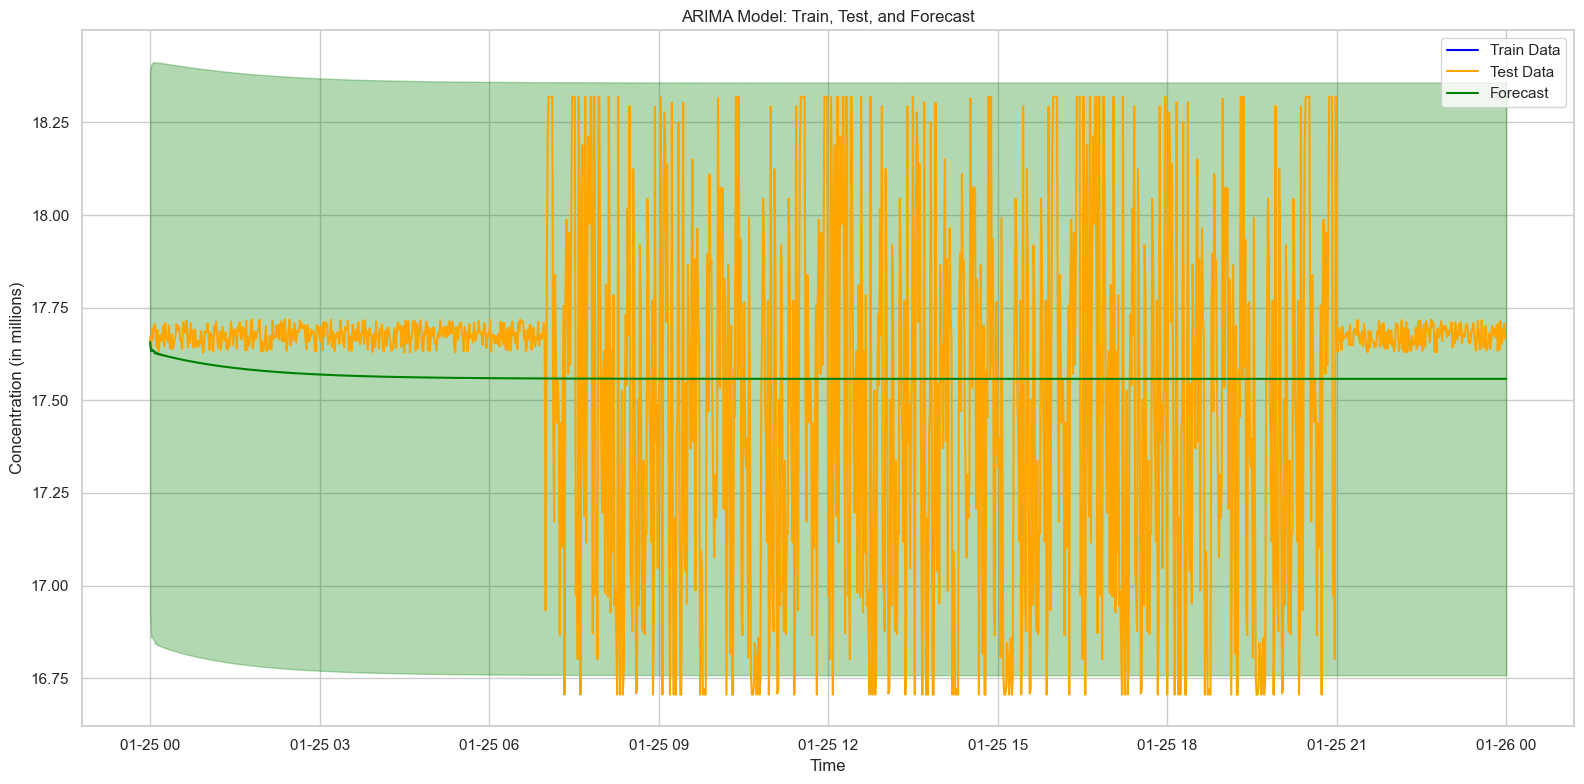

In [58]:
train_end = '2024-01-20'
test_start = '2024-01-21'

train_series = df['log_concentration'][:train_end]
test_series = df['log_concentration'][test_start:]

model = ARIMA(train_series, order=(6, 0, 2))
results = model.fit()

# Print out the summary of the model's fit
print(results.summary())

forecast_start_time = '2024-01-25 00:00:00'
forecast_end_time = '2024-01-25 23:59:00'

# Adjust forecast steps to match the actual data available in test series for this period
forecast_steps = len(test_series[forecast_start_time:forecast_end_time])

# Generate forecast
forecast = results.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=forecast_start_time, periods=forecast_steps, freq='T')

# Extract filtered test data for visualization
filtered_train_series = train_series[forecast_start_time:forecast_end_time]
filtered_test_series = test_series[forecast_start_time:forecast_end_time]

forecast_values = forecast.predicted_mean
actual_values = filtered_test_series.values

# Ensure that the length of forecast_values and actual_values are the same
forecast_values = forecast_values[:len(actual_values)]

# Calculate performance metrics
mae = mean_absolute_error(actual_values, forecast_values)
mse = mean_squared_error(actual_values, forecast_values)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_values - forecast_values) / actual_values)) * 100
aic = results.aic
bic = results.bic
print(f"Mean Absolute Error (MAE): {mae:.10f}")
print(f"Mean Squared Error (MSE): {mse:.10f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.10f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Akaike Information Criterion (AIC): {aic:.2f}")
print(f"Bayesian Information Criterion (BIC): {bic:.2f}")
# Plot train, test, and forecast data
plt.figure(figsize=(16, 8))

# Plot train data
plt.plot(filtered_train_series.index, filtered_train_series, label='Train Data', color='blue')

# Plot test data
plt.plot(filtered_test_series.index, filtered_test_series, label='Test Data', color='orange')

# Plot forecast data
plt.plot(forecast_index, forecast_values, color='green', label='Forecast')

# Plot forecast confidence intervals
plt.fill_between(forecast_index,
                 forecast.conf_int().iloc[:, 0], 
                 forecast.conf_int().iloc[:, 1], 
                 color='green', alpha=0.3)

# Add labels and legend
plt.title('ARIMA Model: Train, Test, and Forecast')
plt.xlabel('Time')
plt.ylabel('Concentration (in millions)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


## --------------------- **Exponential Smoothing: Holt-Winters model** ---------------------

                          ExponentialSmoothing Model Results                         
Dep. Variable:            concentration   No. Observations:                     28820
Model:             ExponentialSmoothing   SSE                 8872205983537592320.000
Optimized:                         True   AIC                              961509.364
Trend:                   Multiplicative   BIC                              961740.892
Seasonal:                      Additive   AICC                             961509.429
Seasonal Periods:                    24   Date:                      Wed, 22 Jan 2025
Box-Cox:                          False   Time:                              23:45:38
Box-Cox Coeff.:                    None                                              
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0757143                alpha  

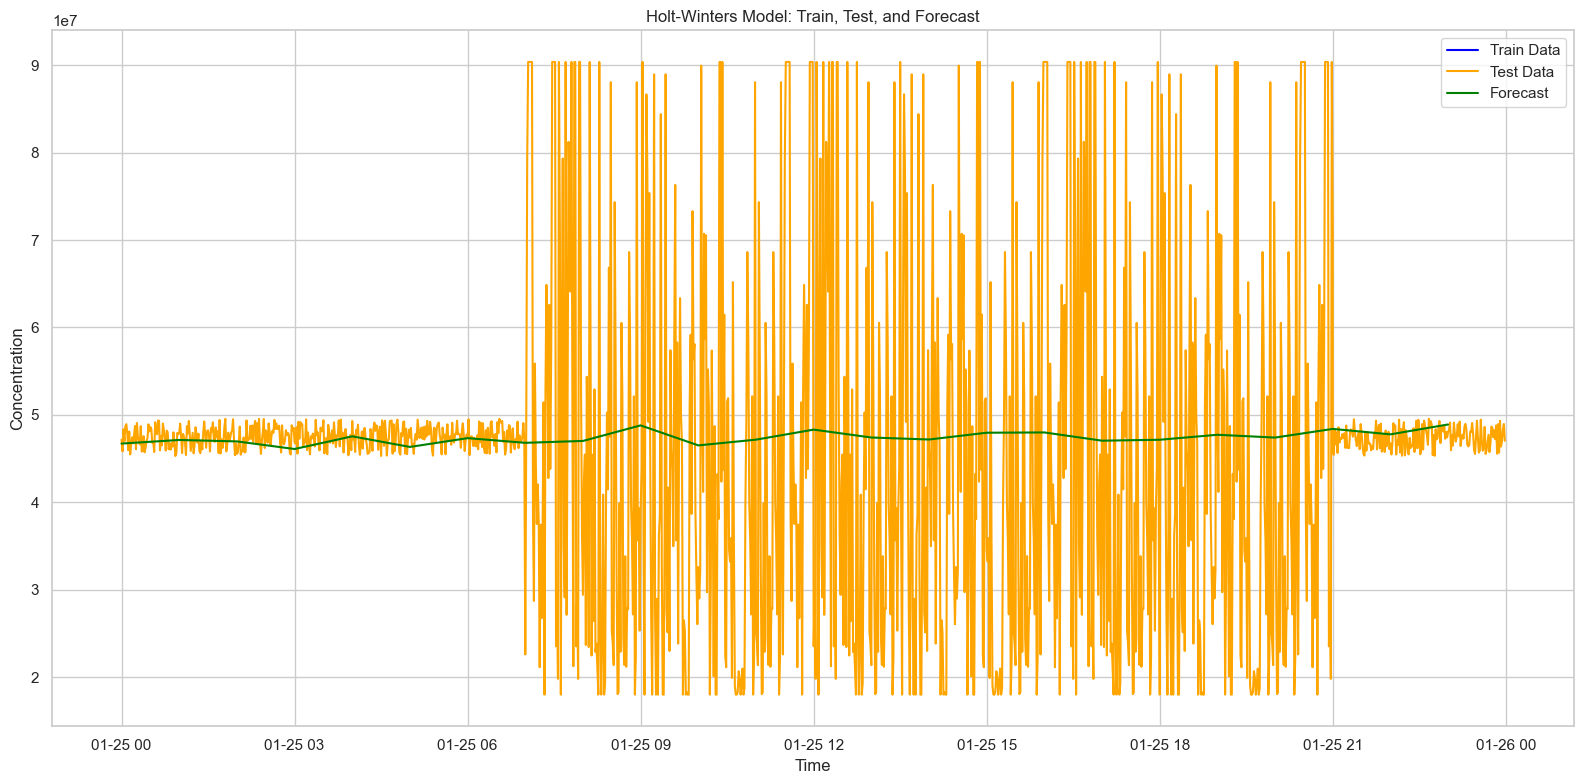

In [59]:
train_end = '2024-01-20'
test_start = '2024-01-21'

train_series = df['concentration'][:train_end]
test_series = df['concentration'][test_start:]

hw_model = ExponentialSmoothing(
    train_series,
    trend="mul",
    seasonal="add",
    seasonal_periods=24  # Assuming hourly data with daily seasonality
).fit()

print(hw_model.summary())

forecast_start_time = pd.to_datetime('2024-01-25 00:00:00')
forecast_end_time = pd.to_datetime('2024-01-25 23:59:00')

forecast_steps = int((forecast_end_time - forecast_start_time).total_seconds() / 3600) + 1

# Generate forecast for the exact length of forecast_steps
forecast = hw_model.forecast(forecast_steps)
forecast_index = pd.date_range(start=forecast_start_time, periods=forecast_steps, freq='H')

# Filter the test data and ensure alignment with the forecast range
filtered_test_series = test_series[forecast_start_time:forecast_end_time]

# Align forecast values and actual test values
actual_values = filtered_test_series.values
forecast_values = forecast[:len(actual_values)]  # Trim forecast to match actual_values length

# Calculate performance metrics only if lengths match
if len(actual_values) == len(forecast_values) and len(actual_values) > 0:
    mae = mean_absolute_error(actual_values, forecast_values)
    mse = mean_squared_error(actual_values, forecast_values)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual_values - forecast_values) / actual_values)) * 100  # MAPE in percentage terms
    aic = hw_model.aic
    bic = hw_model.bic

    # Print metrics
    print(f"Mean Absolute Error (MAE): {mae:.6f}")
    print(f"Mean Squared Error (MSE): {mse:.6f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"Akaike Information Criterion (AIC): {aic:.2f}")
    print(f"Bayesian Information Criterion (BIC): {bic:.2f}")
# Plot train, test, and forecast data
plt.figure(figsize=(16, 8))
plt.plot(filtered_train_series.index, filtered_train_series,  label='Train Data', color='blue')
plt.plot(filtered_test_series.index, filtered_test_series, label='Test Data', color='orange')
plt.plot(forecast_index, forecast_values, color='green', label='Forecast')
plt.title('Holt-Winters Model: Train, Test, and Forecast')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Multivariate Time Series Analysis

In [76]:
time_series_data = df[["LDSA", "mass", "concentration", "T", "RH", 
    "No.Motor", "No.tuktuk", "diam", "No.bus", 
    "windspeed", "No.car"]] / 1e6 

# Train-test split
train = time_series_data.iloc[:int(0.8 * len(time_series_data))]
test = time_series_data.iloc[int(0.8 * len(time_series_data)):]

# Perform Johansen's cointegration test
result = coint_johansen(train, det_order=0, k_ar_diff=1)

# Print test statistics
print("Eigenvalues:")
print(result.eig)
print("\nTrace Statistic:")
print(result.lr1)
print("\nCritical Values for Trace Statistic:")
print(result.cvt)

print("\nMaximum Eigenvalue Statistic:")
print(result.lr2)
print("\nCritical Values for Maximum Eigenvalue Statistic:")
print(result.cvm)

Eigenvalues:
[0.45108965 0.37074119 0.35835002 0.31491591 0.30039282 0.24790611
 0.23382972 0.16288288 0.09966152 0.06914056 0.03329742]

Trace Statistic:
[113695.84003862  92261.86692217  75709.42637657  59853.81018203
  46338.72222481  33573.24108803  23392.8351527   13875.05413626
   7521.86024268   3770.34402718   1210.11044117]

Critical Values for Trace Statistic:
[[277.374  285.1402 300.2821]
 [232.103  239.2468 253.2526]
 [190.8714 197.3772 210.0366]
 [153.6341 159.529  171.0905]
 [120.3673 125.6185 135.9825]
 [ 91.109   95.7542 104.9637]
 [ 65.8202  69.8189  77.8202]
 [ 44.4929  47.8545  54.6815]
 [ 27.0669  29.7961  35.4628]
 [ 13.4294  15.4943  19.9349]
 [  2.7055   3.8415   6.6349]]

Maximum Eigenvalue Statistic:
[21433.97311646 16552.44054559 15855.61619454 13515.08795722
 12765.48113678 10180.40593534  9517.78101643  6353.19389358
  3751.5162155   2560.23358601  1210.11044117]

Critical Values for Maximum Eigenvalue Statistic:
[[67.1307 70.5392 77.4877]
 [61.2041 64.504  

- Eigenvalues: Indicate the strength of cointegrating relationships. Larger values suggest stronger cointegration.

- Eigenvalues: These represent the strength of the cointegration relationships. Higher eigenvalues suggest stronger cointegration.

- Trace Statistic:

    - This tests the null hypothesis that there are at most 
    𝑟 cointegrating relationships.

    - Compare the trace statistics to the critical values at 5% significance (middle column).

    - If the trace statistic exceeds the critical value, reject the null hypothesis, meaning more cointegration relationships exist.

- Maximum Eigenvalue Statistic:

    - Similar to the trace test but evaluates the null hypothesis of exactly 
    𝑟 cointegrating relationships.
    - A higher statistic than the critical value indicates the presence of an additional cointegration relationship.

- Conclusion:
Based on the results, we have evidence of 5-6 cointegrating relationships since the trace statistic exceeds the 5% critical values up to 
𝑟
=
5
r=5 or 
𝑟
=
6
r=6.
This implies that several variables in the dataset move together in the long term despite short-term fluctuations.

## -------------------------------- Vector Autoregressive Model -------------------------------- 

Optimal Lag Order: {'aic': 15, 'bic': 15, 'hqic': 15, 'fpe': 15}
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 21, Jan, 2025
Time:                     00:08:36
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  -0.831532
Nobs:                     28805.0    HQIC:                 -0.843607
Log likelihood:          -69450.6    FPE:                   0.427702
AIC:                    -0.849329    Det(Omega_mle):        0.426783
--------------------------------------------------------------------
Results for equation concentration
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                    -0.000091         0.005347           -0.017           0.986
L1.concentration          0.316907         0.005895     

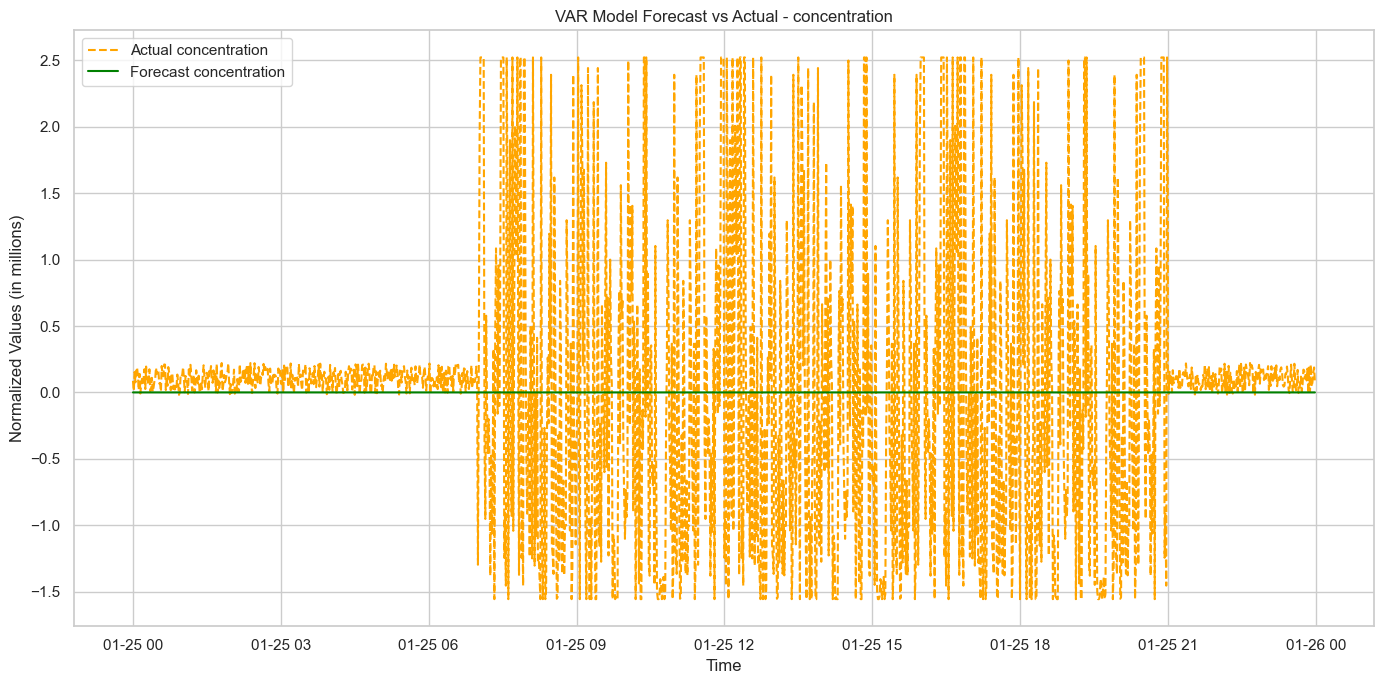

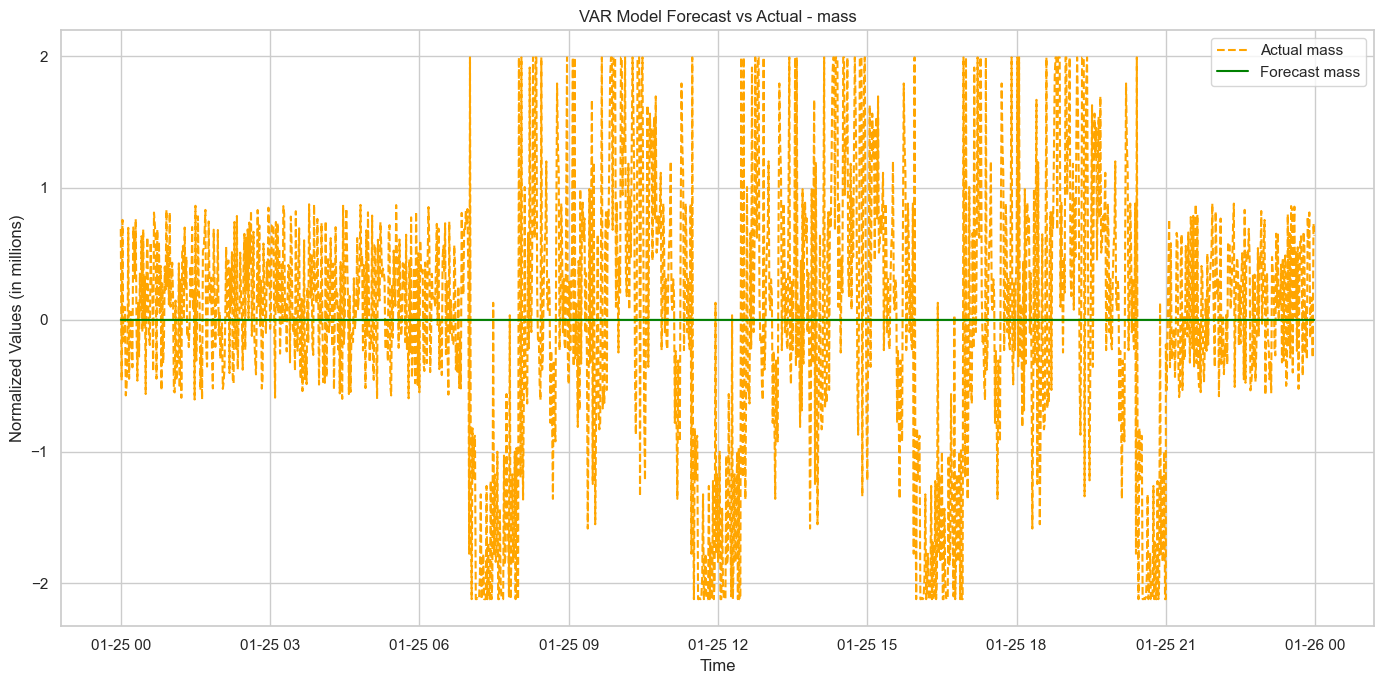

Performance Metrics for concentration:
Mean Absolute Error (MAE): 0.6835556014
Mean Squared Error (MSE): 0.9999561092
Root Mean Squared Error (RMSE): 0.9999780543
Mean Absolute Percentage Error (MAPE): 100.27%

Performance Metrics for mass:
Mean Absolute Error (MAE): 0.7708718413
Mean Squared Error (MSE): 1.0003503578
Root Mean Squared Error (RMSE): 1.0001751635
Mean Absolute Percentage Error (MAPE): 100.23%

Performance Metrics Summary:
                    MAE       MSE      RMSE    MAPE (%)
concentration  0.683556  0.999956  0.999978  100.271185
mass           0.770872  1.000350  1.000175  100.227292


In [77]:
train_end = '2024-01-20'
test_start = '2024-01-21'

time_series_data = df[["concentration", 'mass']]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(time_series_data)
scaled_data = pd.DataFrame(scaled_data, index=time_series_data.index, columns=time_series_data.columns)

# Train-test split
train_series = scaled_data.loc[:train_end]
test_series = scaled_data.loc[test_start:]

# Fit the VAR model
model = VAR(train_series)
lag_order = model.select_order(maxlags=15)  # Automatically select optimal lag
print("Optimal Lag Order:", lag_order.selected_orders)

# Train the model with the optimal lag
var_model = model.fit(lag_order.selected_orders['aic'])

# Print model summary
print(var_model.summary())

forecast_steps = len(test_series)
forecast = var_model.forecast(train_series.values[-lag_order.selected_orders['aic']:], steps=forecast_steps)

# Convert forecast to DataFrame
forecast_df = pd.DataFrame(forecast, index=test_series.index, columns=train_series.columns)

# Define the specific date range for forecasting visualization
forecast_start_time = '2024-01-25 00:00:00'
forecast_end_time = '2024-01-25 23:59:00'

# Filter the test series and forecast for the specific date range
filtered_test_series = test_series.loc[forecast_start_time:forecast_end_time]
filtered_forecast_df = forecast_df.loc[forecast_start_time:forecast_end_time]

# Plot the forecast vs actual values for each feature separately
for column in test_series.columns:
    plt.figure(figsize=(14, 7))
    plt.plot(filtered_test_series.index, filtered_test_series[column], label=f'Actual {column}', linestyle='dashed', color='orange')
    plt.plot(filtered_forecast_df.index, filtered_forecast_df[column], label=f'Forecast {column}', color='green')
    plt.title(f'VAR Model Forecast vs Actual - {column}')
    plt.xlabel('Time')
    plt.ylabel('Normalized Values (in millions)')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

# Calculate performance metrics for all features
performance_metrics = {}

for column in test_series.columns:
    actual_values = test_series[column].values
    forecast_values = forecast_df[column].values
    
    mae = mean_absolute_error(actual_values, forecast_values)
    mse = mean_squared_error(actual_values, forecast_values)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual_values - forecast_values) / actual_values)) * 100
    
    performance_metrics[column] = {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "MAPE (%)": mape
    }

    print(f"Performance Metrics for {column}:")
    print(f"Mean Absolute Error (MAE): {mae:.10f}")
    print(f"Mean Squared Error (MSE): {mse:.10f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.10f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print()

# Display all performance metrics in a tabular format
performance_df = pd.DataFrame(performance_metrics).T
print("Performance Metrics Summary:")
print(performance_df)


# ---------------------------- BiLSTM model (Univariate) ----------------------------

In [64]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


# BiLSTM Model
class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=n_layers, 
                            bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        x = lstm_out[:, -1, :]  # Last time step
        x = self.fc(x)
        return x


# Data Preparation
def prepare_data(series, look_back=1):
    X, y = [], []
    for i in range(len(series) - look_back):
        end_ix = i + look_back
        seq_x, seq_y = series[i:end_ix], series[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


def create_datasets(train_data, test_data, look_back, val_split=0.1):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    train_scaled = scaler.fit_transform(train_data)
    test_scaled = scaler.transform(test_data)

    train_X, train_y = prepare_data(train_scaled, look_back)
    test_X, test_y = prepare_data(test_scaled, look_back)

    val_split_index = int(len(train_X) * (1 - val_split))
    val_X, val_y = train_X[val_split_index:], train_y[val_split_index:]
    train_X, train_y = train_X[:val_split_index], train_y[:val_split_index]

    return train_X, train_y, val_X, val_y, test_X, test_y, scaler


# Training Function
def train_model(model, train_loader, val_loader, num_epochs, learning_rate, patience=5):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    early_stopping = EarlyStopping(patience=patience)

    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for seq, labels in train_loader:
            seq, labels = seq.to(device), labels.to(device)
            optimizer.zero_grad()
            y_pred = model(seq)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation loss
        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for seq, labels in val_loader:
                seq, labels = seq.to(device), labels.to(device)
                y_pred = model(seq)
                val_loss += criterion(y_pred, labels).item()
        val_loss /= len(val_loader)

        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.6f}, Val Loss: {val_loss:.6f}")

        # Early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

    return train_losses, val_losses


# Evaluation Function
def evaluate_model(model, test_loader, is_multivariate=False):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for seq, labels in test_loader:
            seq, labels = seq.to(device), labels.to(device)
            y_pred = model(seq)
            if is_multivariate:
                y_pred = y_pred.squeeze(-1)
            predictions.append(y_pred.cpu().numpy())
            actuals.append(labels.cpu().numpy())
    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)
    if is_multivariate:
        predictions = predictions.reshape(-1)
        actuals = actuals[:, 0]
    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    print(f"MAE: {mae:.6f}, MSE: {mse:.6f}, RMSE: {rmse:.6f}")
    return predictions, actuals, mae, mse, rmse


# Plot Results
def plot_results(train_data, test_data, predictions, title, scaler, forecast_start_time, forecast_end_time, target_index=0):
    # Inverse transform train and test data
    train_data = scaler.inverse_transform(train_data)[:, target_index]
    test_data = scaler.inverse_transform(test_data)[:, target_index]
    predictions = scaler.inverse_transform(
        np.concatenate([np.zeros((len(predictions), scaler.n_features_in_ - 1)), predictions.reshape(-1, 1)], axis=1)
    )[:, target_index]

    # Define indices for test data and predictions
    test_index = pd.date_range(start=test_start, periods=len(test_data), freq='H')

    # Define the forecast range
    forecast_start_time = pd.to_datetime(forecast_start_time)
    forecast_end_time = pd.to_datetime(forecast_end_time)

    # Filter the train data to match the forecast range
    train_index = pd.date_range(start=pd.to_datetime(test_start) - pd.Timedelta(hours=len(train_data)), periods=len(train_data), freq='H')
    filtered_train_mask = (train_index >= forecast_start_time) & (train_index <= forecast_end_time)
    filtered_train_series = train_data[filtered_train_mask]
    filtered_train_index = train_index[filtered_train_mask]

    # Filter the test data and predictions to match the forecast range
    mask = (test_index >= forecast_start_time) & (test_index <= forecast_end_time)
    filtered_test_series = test_data[mask]
    filtered_predictions = predictions[mask]
    filtered_test_index = test_index[mask]

    # Generate forecast range index
    forecast_steps = len(filtered_predictions)
    forecast_index = pd.date_range(start=forecast_start_time, periods=forecast_steps, freq='H')

    # Plot the results
    plt.figure(figsize=(16, 8))
    plt.plot(filtered_train_index, filtered_train_series, label='Train Data (Filtered)', color='blue')
    plt.plot(filtered_test_index, filtered_test_series, label='Test Data', color='orange')
    plt.plot(forecast_index, filtered_predictions, label='Forecast', color='green')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Concentration')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()


# Additional Plots
def plot_error_metrics(metrics):
    plt.bar(metrics.keys(), metrics.values(), color=['blue', 'orange', 'green'])
    plt.title("Error Metrics")
    plt.ylabel("Value")
    plt.show()


def plot_training_curves(train_losses, val_losses):
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.title("Training vs Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

def plot_residuals(actuals, predictions):
    residuals = actuals - predictions
    plt.figure(figsize=(10, 6))
    plt.plot(residuals, label="Residuals", color="red")
    plt.axhline(y=0, color="black", linestyle="--")
    plt.title("Residuals Plot")
    plt.legend()
    plt.show()

{'bidirectional': False, 'dropout': 0.1, 'hidden_dim': 128, 'learning_rate': 0.001, 'n_layers': 2, 'num_epochs': 20, 'patience': 5}


Epoch 1/15, Train Loss: 0.188395, Val Loss: 0.130447
Epoch 2/15, Train Loss: 0.052705, Val Loss: 0.092298
Epoch 3/15, Train Loss: 0.009750, Val Loss: 0.010860
Epoch 4/15, Train Loss: 0.008303, Val Loss: 0.006557
Epoch 5/15, Train Loss: 0.004774, Val Loss: 0.007025
Epoch 6/15, Train Loss: 0.006920, Val Loss: 0.002598
Epoch 7/15, Train Loss: 0.003087, Val Loss: 0.004313
Epoch 8/15, Train Loss: 0.005040, Val Loss: 0.003140
Epoch 9/15, Train Loss: 0.002889, Val Loss: 0.004408
Epoch 10/15, Train Loss: 0.005056, Val Loss: 0.002816
Epoch 11/15, Train Loss: 0.003534, Val Loss: 0.002104
Epoch 12/15, Train Loss: 0.002369, Val Loss: 0.003873
Epoch 13/15, Train Loss: 0.002911, Val Loss: 0.002398
Epoch 14/15, Train Loss: 0.002303, Val Loss: 0.002814
Epoch 15/15, Train Loss: 0.003747, Val Loss: 0.001798
MAE: 0.025202, MSE: 0.001789, RMSE: 0.042294


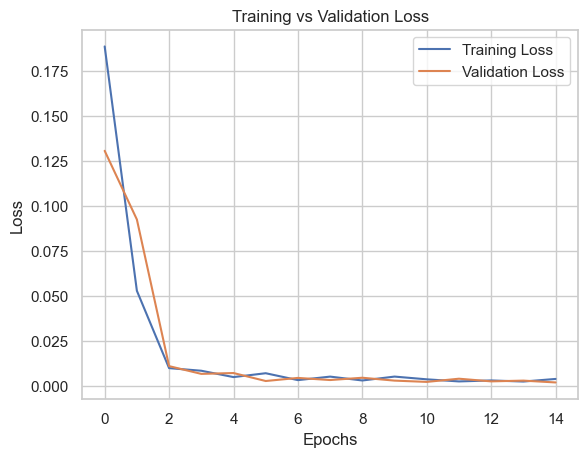

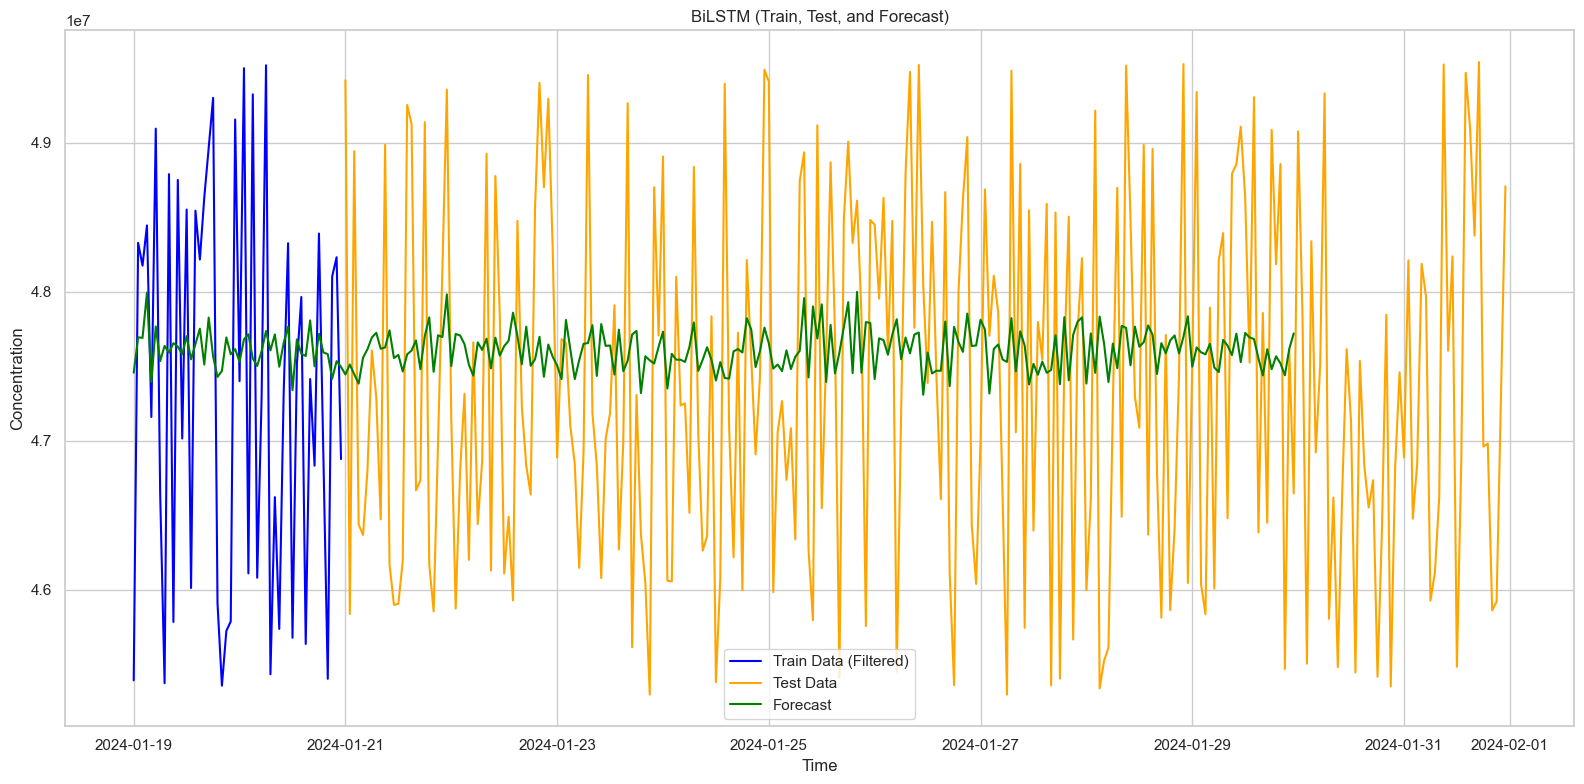

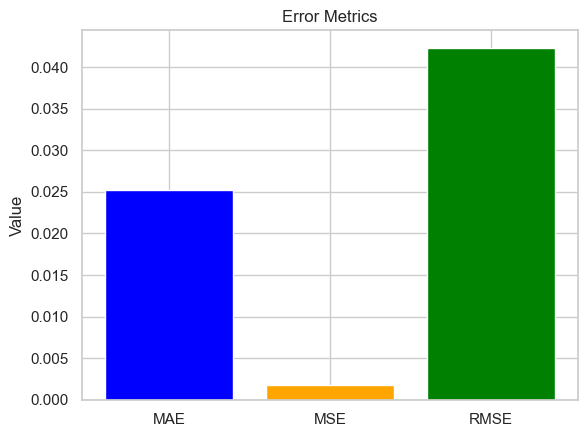

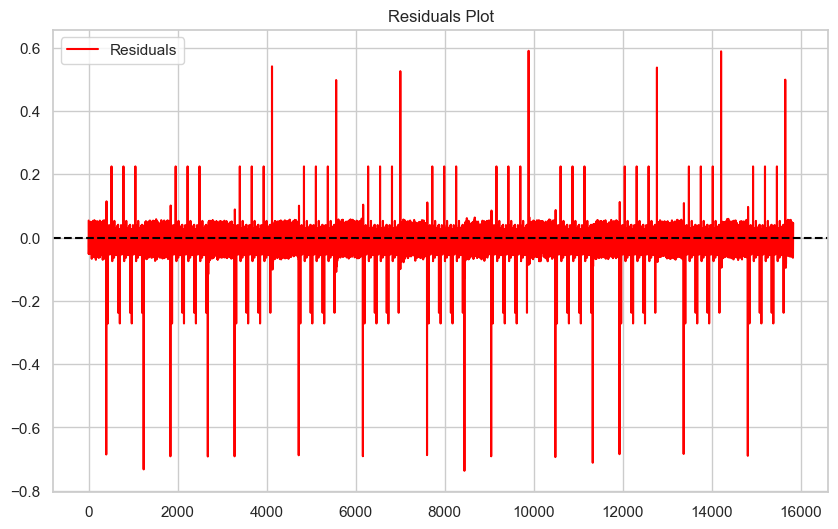

In [65]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_end = '2024-01-20'
test_start = '2024-01-21'

forecast_start_time = '2024-01-19 00:00:00'
forecast_end_time = '2024-01-31 23:59:00'

look_back = 25

train_data = df.loc[:train_end, ['concentration']].values
test_data = df.loc[test_start:, ['concentration']].values

train_X, train_y, val_X, val_y, test_X, test_y, scaler = create_datasets(train_data, test_data, look_back)

train_data = TensorDataset(torch.Tensor(train_X).to(device), torch.Tensor(train_y).to(device))
val_data = TensorDataset(torch.Tensor(val_X).to(device), torch.Tensor(val_y).to(device))
test_data = TensorDataset(torch.Tensor(test_X).to(device), torch.Tensor(test_y).to(device))

train_loader = DataLoader(train_data, batch_size=8, shuffle=False)
val_loader = DataLoader(val_data, batch_size=8, shuffle=False)
test_loader = DataLoader(test_data, batch_size=8, shuffle=False)

model = BiLSTMModel(input_dim=1, hidden_dim=128, output_dim=1, n_layers=2, bidirectional=False, dropout=0.1).to(device)

train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs=15, learning_rate=0.001, patience=5)
predictions, actuals, mae, mse, rmse = evaluate_model(model, test_loader)

plot_training_curves(train_losses, val_losses)
plot_results(train_y, test_y, predictions, "BiLSTM (Train, Test, and Forecast)", scaler, forecast_start_time=forecast_start_time, forecast_end_time=forecast_end_time)
plot_error_metrics({"MAE": mae, "MSE": mse, "RMSE": rmse})
plot_residuals(actuals, predictions)